# **Basic Well Log Interpretation - Final Project**
Initial code from https://github.com/petroGG/Basic-Well-Log-Interpretation/tree/master<br>

# **0. Import Python Library**

In [1]:
# Plotting and Data Manipulation
import pandas as pd
import numpy as np
import math

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib import gridspec
import altair as alt

import lasio

# **1. Read LAS data and Change the Format into Dataframe**

#### **1.1 Column name adjustments for each well** <br>
Do a rename for columns that don't match the sourcecode. For data columns that are intended to be plotted, they must match as follows:

- **DEPT**
- **Traject 1: GR, CALI, SP**

- **Traject 2: DR, MR, SR**

- **Traject 3: RHOB, NPHI, DT**

In [2]:
def read_las(file_name, well_name, columns_to_rename, columns_to_keep, keep_original = False):
  file_name = file_name
  data = lasio.read(file_name).df().reset_index()

  data = data.rename(columns=columns_to_rename)
  data = data.filter(columns_to_keep)

  # Insert Well name columns in the first col index
  data.insert(0, 'WELL', well_name)

  if keep_original:
    data.fillna(-999.25, inplace=True)

  return data

In [3]:
file_name = "../data/raw/lld-18_wire_lima.las"
well_name = "LLD-18"
renamed_columns = {'DEPTH' : 'DEPT', 'RT' : 'DR', 'ILM' : 'MR', 'LLS':'SR', 'NPHI_CORR':'NPHI', "DT_MAA" : "DT"} # {nama_asli : nama_baru, ... , dst}
columns = ["DEPT","GR", "CALI", "MR", "DR", "SR", "NPHI", "RHOB", "DT", "VSH", "RW", "WELL"]

data = read_las(file_name, well_name, renamed_columns, columns, keep_original = False)

Only engine='normal' can read wrapped files


In [4]:
data.describe()

,DEPT,GR,DR,SR,NPHI,RHOB,DT,VSH,RW
count,10133.000000,9291.000000,9271.000000,9271.000000,2478.000000,2501.000000,0.0,6034.000000,10133.000000
mean,2533.000000,66.550534,1.636807,1.017569,0.469376,2.208437,NaN,0.549701,0.131896
std,1462.644736,19.689320,10.749416,2.245749,0.073722,0.117789,NaN,0.333390,0.029389
min,0.000000,10.732400,0.100000,0.100000,0.131300,1.462000,NaN,0.000000,0.094082
25%,1266.500000,53.827400,0.761000,0.672200,0.429000,2.178000,NaN,0.205700,0.107492
50%,2533.000000,72.621100,0.863400,0.792200,0.469800,2.231200,NaN,0.650950,0.125107
75%,3799.500000,80.739800,1.112650,1.023750,0.505900,2.270100,NaN,0.835000,0.149839
max,5066.000000,108.563800,200.000000,200.000000,0.864600,2.687000,NaN,1.000000,0.207732


# **2. Functions for Data Distribution Plots**

### ***2.1. Data distribution based on Histogram Plot***

In [5]:
def histplot(data, columns_to_plot, columns_unit, depth_start=data.DEPT.min(), depth_end=data.DEPT.max()):
    # Get unique wells and assign colors
    wells = data['WELL'].unique()
    colors = sns.color_palette('viridis', n_colors=len(wells))

    # Create subplots for histograms
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle(f'DATA DISTRIBUTION (HISTOGRAM PLOT) from {depth_start}ft to {depth_end}ft \n', fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.3)

    # List of columns and their corresponding units
    columns = columns_to_plot
    units = columns_unit

    for i, ax in enumerate(axes.flat):
        if i < len(columns):
            column_name = columns[i]
            column_unit = units[i]  # Specify the unit for the column
            ax.set_title(column_name)

            # Plot histograms for each well with different colors
            for well, color in zip(wells, colors):
                well_data = data[(data['WELL'] == well) & (data['DEPT'] >= depth_start) & (data['DEPT'] <= depth_end)]
                sns.histplot(well_data[column_name].dropna(), bins=50, color=color, ax=ax, kde=True, label=well)

            ax.set_xlabel(f"{column_name} [{column_unit}]")  # Include the specified unit in the x-axis label
            ax.legend(title='WELL')

    # Remove empty subplots if there are more plots than columns
    if len(columns) < len(axes.flat):
        for i in range(len(columns), len(axes.flat)):
            fig.delaxes(axes.flat[i])

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


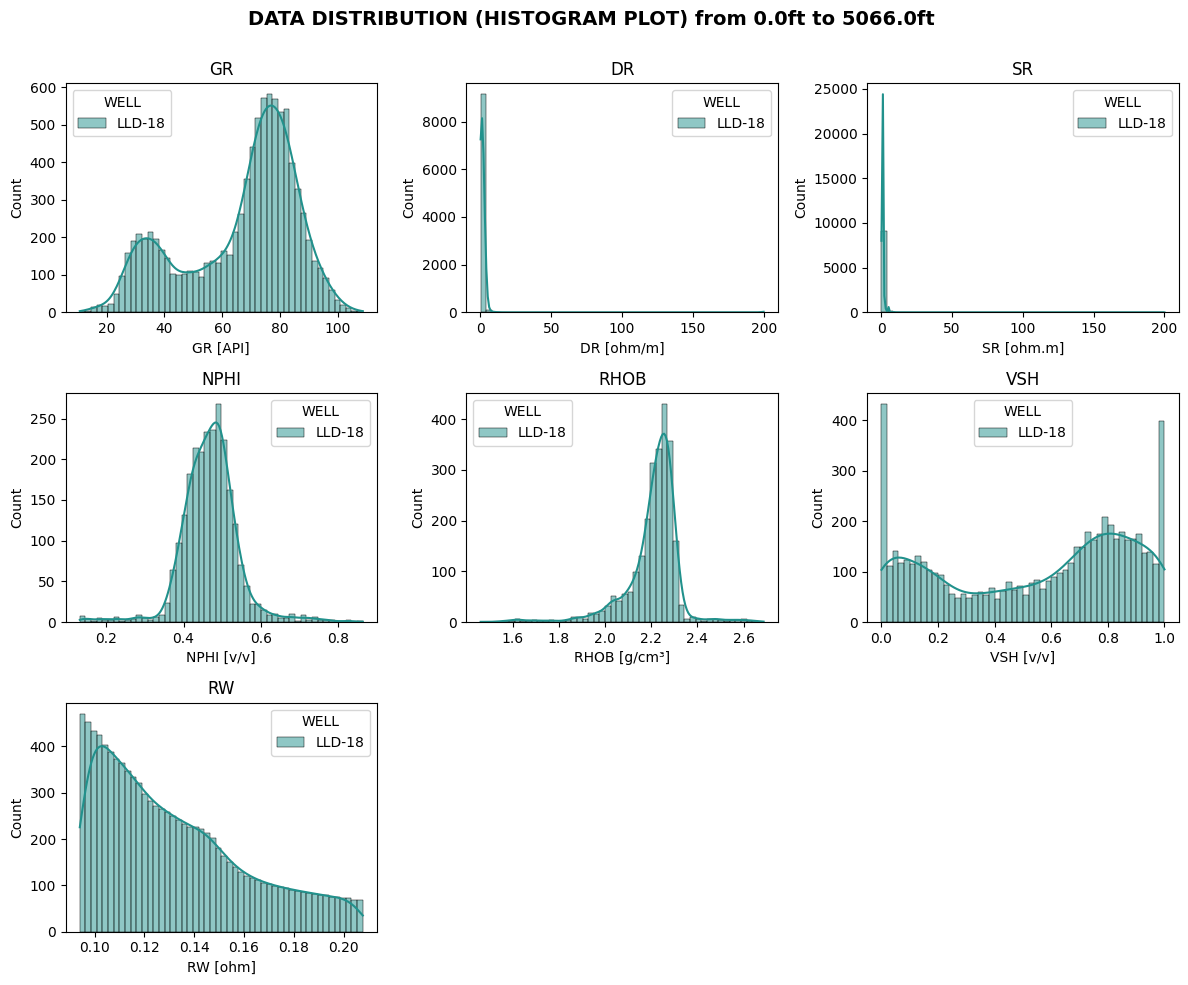

In [6]:
columns_to_plot = ["GR", "DR", "SR", "NPHI", "RHOB", "VSH", "RW"]
columns_unit = ["API", "ohm/m", "ohm.m", "v/v", "g/cm³", "v/v", "ohm"]

histplot(data, columns_to_plot, columns_unit)

## **3. Select the Well for Calculations**

In [7]:
# Create a copy of the data for calculations
calculation_data = data[data['WELL'] == well_name].copy()

### ***3.1. Input Core Data (Porosity and Permeability) for Selected Well***
this code block is still **experimental**, make sure you know what you're doing if u want to change any part of the code

In [8]:
calculation_data["core_por"] = ""
calculation_data["core_perm"] = ""

# Define the number of random samples you want
num_samples = 100  # You can change this to the desired number of samples

# Generate random values for 'DEPT' between 900 and 4300
dept_values = np.random.uniform(0, 8400, num_samples)

# Generate random values for 'core_por' between 0 and 1 and "core_perm" between 0 and 1000
core_por_values = np.random.uniform(0, 1, num_samples)
core_perm_values = np.random.uniform(0, 1000, num_samples)

# Create a dictionary with the generated values. This for example only
dict_core = {
    'DEPT': dept_values.tolist(),  # Convert to a list
    'core_por': core_por_values.tolist(),  # Convert to a list
    "core_perm" : core_perm_values.tolist() # Convert to a list
}

# must inpute manually based on core data
"""dict_core = {'DEPT':[4220,4240,4260],
        'DEPT':[4220,4240,4260],
        'core_por':[0.148, 0.287,0.103],
        'core_perm':[0.0001,0.0001,0.0001]
       } """


core_selected_data = pd.DataFrame(dict_core)
calculation_data.set_index("DEPT");

## **4. DISPLAY DATA LOGS**
Display is done by describing a function named combo_plot<br>
combo_plot displays three traject, namely:<br>
- **Traject 1: GR, SP, CALI**
- **Traject 2: Resistivities (ILD, ILM, ILS, LL8, SFL, or other)**
- **Traject 3: Density (RHOB), Sonic(DT) and Neutronic (NPHI)**

In [9]:
# Create the figure and subplots
def combo_plot(data, top_depth, bottom_depth, figure_height, suptitleadjust, SP_range = "auto", CALI_range="auto", GR_range="auto", DR_range="auto", MR_range="auto", SR_range="auto", RHOB_range="auto", NPHI_range="auto", DT_range="auto", ticks_interval="auto"):

    logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,figure_height), sharey=True) #pembuatan format 1 baris 3 kolom, width 12 height 10, dan sumbu y yang sama (sharey)
    fig.suptitle(f"LOG CURVE".upper(), y=suptitleadjust, va='bottom')
    fig.subplots_adjust(wspace=0.1)


    #General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        for (i,j) in zip(formation_depths, formations):
          if ((i>= top_depth) and (i<= bottom_depth)):
            axes.axhline(y=i, linewidth=0.5, color='black')
            axes.text(0.1,i,j, horizontalalignment='center', verticalalignment='center')

        if ticks_interval == "auto":
          axes.yaxis.set_major_locator(ticker.AutoLocator())
          axes.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        else:
          axes.yaxis.set_major_locator(ticker.MultipleLocator(ticks_interval[0]))
          axes.yaxis.set_minor_locator(ticker.MultipleLocator(ticks_interval[1]))

        axes.get_xaxis().set_visible(False)


#First Trajectory: GR, CALI, SP
    #Gamma Ray lot
    if ("GR" in data.columns):
        ax01=ax[0].twiny()
        if GR_range != "auto":
            ax01.set_xlim(GR_range[0],GR_range[1])
        ax01.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        # ax01.yaxis.set_major_locator(ticker.MultipleLocator(50))
        ax01.plot(logs.GR, logs.DEPT, label='GR[api]', color='green')

        if "CALI" in data.columns:
          ax01.spines['top'].set_position(('outward',80))
        elif "SP" in data.columns and "CALI" not in data.columns:
          ax01.spines['top'].set_position(('outward',40))
        elif "CALI" in data.columns and "SP" not in data.columns:
          ax01.spines['top'].set_position(('outward'),40)
        else:
          ax01.spines['top'].set_position(('outward',0))

        ax01.set_xlabel('GR[api]',color='green')
        ax01.tick_params(axis='x', colors='green')

    #Caliper Plot
    if ("CALI" in data.columns):
        ax02=ax[0].twiny()
        if CALI_range != "auto":
            ax02.set_xlim(CALI_range[0], CALI_range[1])
        ax02.plot(logs.CALI, logs.DEPT, '--', label='CALN[in]', color='black')

        if "SP" in data.columns:
          ax02.spines['top'].set_position(('outward',40))
        else:
          ax02.spines['top'].set_position(('outward',0))
        ax02.set_xlabel('CALI[in]',color='black')
        ax02.tick_params(axis='x', colors='black')
        #ax02.axvline(x=7.9, linewidth=2, color='black') #digunakan untuk plot bit size ukuran 7.9 in

    #Spontaneous Potential Plot
    if ("SP" in data.columns):
        ax03=ax[0].twiny()
        if SP_range != "auto":
            ax03.set_xlim(SP_range[0],SP_range[1])
        ax03.spines['top'].set_position(('outward',0))
        ax03.set_xlabel("SP [mV]")
        ax03.plot(logs.SP, logs.DEPT, label='SP[mV]', color='blue')
        ax03.set_xlabel('SP[mV]',color='blue')
        ax03.tick_params(axis='x', colors='blue')
        ax03.grid(True)


#Second Trajectory: DR, MR, SR
    #Deep Resistivity Plot
    if ("DR" in data.columns):
        ax11=ax[1].twiny()
        if DR_range != "auto":
            ax11.set_xlim(DR_range[0],DR_range[1])
        ax11.set_xscale('log')
        ax11.grid(visible=None, which='both')

        if "MR" in data.columns:
          ax11.spines['top'].set_position(('outward',40))
        elif "SR" in data.columns and "MR" not in data.columns:
          ax11.spines['top'].set_position(('outward',40))
        elif "MR" in data.columns and "SR" not in data.columns:
          ax11.spines['top'].set_position(('outward',40))
        else:
          ax11.spines['top'].set_position(('outward',0))

        ax11.set_xlabel('Deep Resistivity [ohm.m]', color='red')
        ax11.plot(logs.DR, logs.DEPT, label='DR [ohm.m]', color='red')
        ax11.tick_params(axis='x', colors='red')

    #Medium Resistivity Plot
    if("MR" in data.columns):
        ax12=ax[1].twiny()
        if MR_range != "auto":
            ax12.set_xlim(MR_range[0],MR_range[1])
        ax12.set_xscale('log')
        ax12.grid(visible=None, which='both')
        if "SR" in data.columns:
          ax12.spines['top'].set_position(('outward',40))
        else:
          ax12.spines['top'].set_position(('outward',0))
        ax12.set_xlabel('Medium Resistivity [ohm.m]', color='purple')
        ax12.plot(logs.MR, logs.DEPT, label='MR [ohm.m]', color='purple')
        ax12.tick_params(axis='x', colors='purple')

    #Shallow Resistivity Plot
    if("SR" in data.columns):
        ax13=ax[1].twiny()
        if SR_range != "auto":
            ax13.set_xlim(SR_range[0],SR_range[1])
        ax13.set_xscale('log')
        ax13.grid(visible=None, which='both')
        ax13.spines['top'].set_position(('outward',0))
        ax13.set_xlabel('Shallow Resistivity [ohm.m]',color='black')
        ax13.plot(logs.SR, logs.DEPT, '--',label='SR[ohm.m]', color='black')
        ax13.tick_params(axis='x', colors='black')


#Third Trajectory: RHOB, NPHI, DT
    #Density Plot
    if ("RHOB" in data.columns):
        ax21=ax[2].twiny()
        if RHOB_range != "auto":
            ax21.set_xlim(RHOB_range[0],RHOB_range[1])
        ax21.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red')

        if "NPHI" in data.columns:
          ax21.spines['top'].set_position(('outward',80))
        elif ("DT" in data.columns and "NPHI" not in data.columns):
          ax21.spines['top'].set_position(('outward',40))
        elif ("NPHI" in data.columns and "DT" not in data.columns):
          ax21.spines['top'].set_position(('outward',40))
        else:
          ax21.spines['top'].set_position(('outward',0))

        ax21.set_xlabel('RHOB[g/cc]',color='red')
        ax21.tick_params(axis='x', colors='red')

    #Neutron Porosity Plot
    if ("NPHI" in data.columns):
        ax22=ax[2].twiny()
        if NPHI_range != "auto":
            ax22.set_xlim(NPHI_range[0],NPHI_range[1])
        ax22.invert_xaxis()
        ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[%]', color='green')

        if "DT" in data.columns:
          ax22.spines['top'].set_position(('outward',40))
        else:
          ax22.spines['top'].set_position(('outward',40))

        ax22.set_xlabel('NPHI[%]', color='green')
        ax22.tick_params(axis='x', colors='green')

    #Sonic Plot
    if ("DT" in data.columns):
        ax23=ax[2].twiny()
        ax23.grid(True, which='both')
        if DT_range != "auto":
            ax23.set_xlim(DT_range[0],DT_range[1])
        ax23.spines['top'].set_position(('outward',0))
        ax23.set_xlabel('DT[us/ft]')
        ax23.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
        ax23.set_xlabel('DT[us/ft]', color='blue')
        ax23.tick_params(axis='x', colors='blue')

    plt.show()

### **4.1 Define Formation**

this where you put your well formation structure, the plot will automatically create an horizontal line to anotate the formation in the corresponding depth

Note to new users:
1. **Make sure the number of elements in formation and formation_depths are equal**
2. **The formation depth should'nt exceed max depth in your data**
3. **Put the formation list and formation depths in sequential order**

In [10]:
formations = ('Torok','Pebble SH','Walakpa SS', 'J-Klingak','Barrow SS','Klingak SH','T-Sag River SS', 'Shublik','Basement')
formation_depths =(100,1701,2071, 2200, 3102,3224,3258,3633)

### **4.2 Adjust NPHI with correction factor -> convert sandstone to limestone scale or otherwise**

In [11]:
calculation_data["NPHI"] = calculation_data["NPHI"] - 0.04

### **5.1. Full depth display**

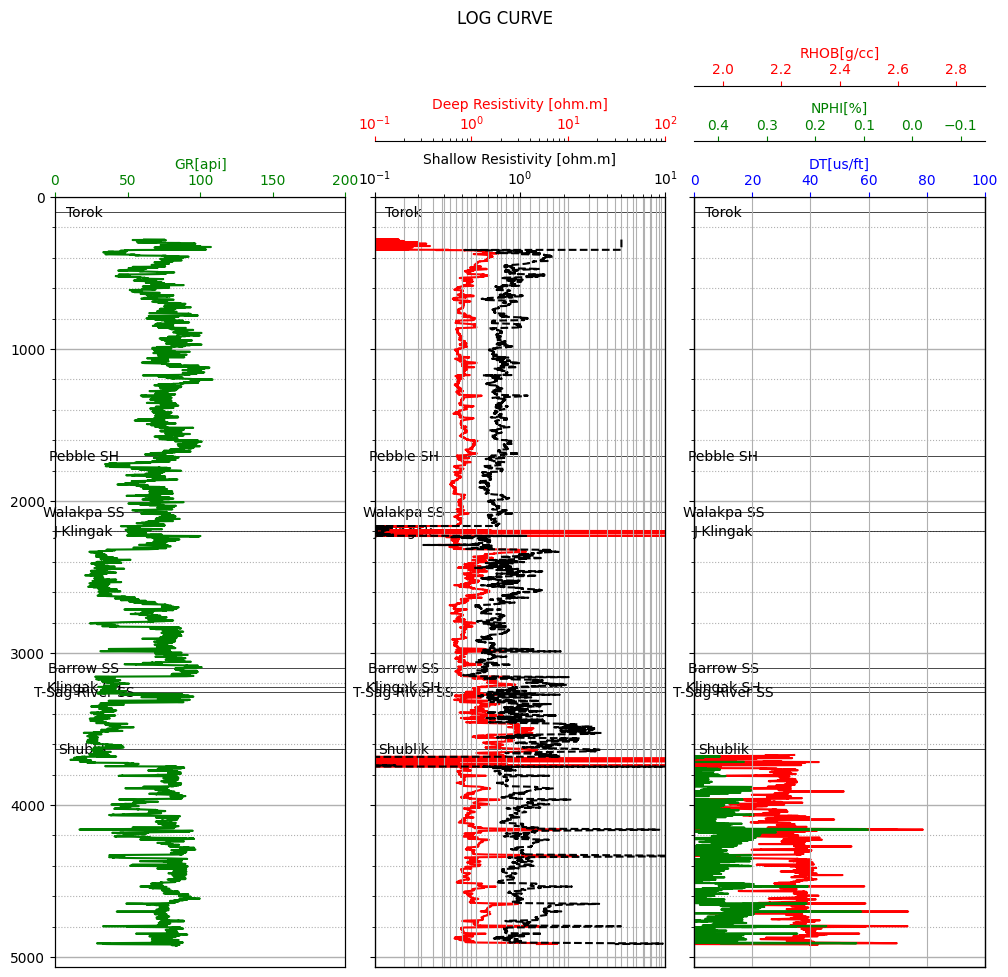

In [12]:
# DISPLAYS LOG DATA FROM THE END TO THE BOTTOM (MENTAHAN)
''' default values if theres no given unit range input in combo plot:
      SP_range = "auto", CALI_range="auto", GR_range="auto",
      DR_range="auto", MR_range="auto", SR_range="auto",
      RHOB_range="auto", NPHI_range="auto", DT_range="auto",
      ticks_interval="auto"
'''

combo_plot(
    calculation_data,
    calculation_data.DEPT.min(),
    calculation_data.DEPT.max(),
    10,               #figure height in inch
    1.05,               #title position
    SP_range=[0,100],
    GR_range=[0,200],
    SR_range=[0.1,10],
    MR_range=[0.1,100],
    DR_range=[0.1,100],
    NPHI_range=[-0.15,0.45],
    RHOB_range=[1.9,2.9],
    DT_range=[0,100],
    ticks_interval="auto"
    )

### **5.2. Selected Depth Display**

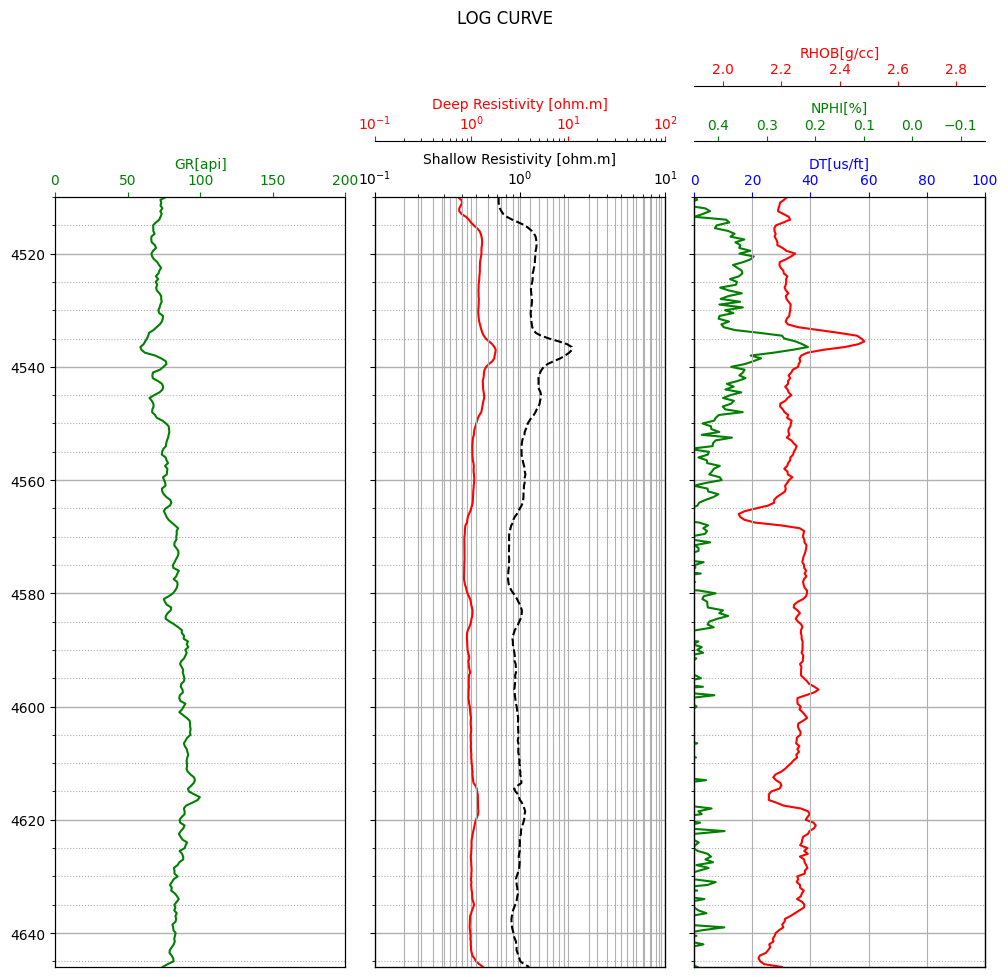

In [13]:
#MENAMPILKAN DATA LOG DARI UJUNG ATAS SAMPAI BAWAH YANG DIINGINKAN

depth_start = 4510
depth_end = 4646

# DISPLAYS LOG DATA FROM THE END TO THE BOTTOM (MENTAHAN)
''' default values :
      SP_range = "auto", CALI_range="auto", GR_range="auto",
      DR_range="auto", MR_range="auto", SR_range="auto",
      RHOB_range="auto", NPHI_range="auto", DT_range="auto",
      ticks_interval="auto"
'''

combo_plot(
    calculation_data,
    depth_start,
    depth_end,
    10,               #figure height in inch
    1.05,               #title position
    SP_range=[0,100],
    GR_range=[0,200],
    SR_range=[0.1,10],
    MR_range=[0.1,100],
    DR_range=[0.1,100],
    NPHI_range=[-0.15,0.45],
    RHOB_range=[1.9,2.9],
    DT_range=[0,100],
    ticks_interval="auto"
    )

### **5.3. Custom Variable Display**

In [14]:

def custom_interpretation_plot(logs, depth_start, depth_end, custom_logs, units):
    num_tracks = len(custom_logs)
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(15, 20), sharey=True)
    fig.suptitle("Custom Interpretation Plot", fontsize=22)

    # Calculate top value with less free space based on the number of tracks
    top_value = 1 - 0.015 * num_tracks

    # Adjust top parameter to leave less free space at the top
    fig.subplots_adjust(top=top_value, wspace=0.2)

    units = units  # in list

    depth_range = depth_end - depth_start

    # General setting for all axes
    for axes in ax:
        axes.set_ylim(depth_start, depth_end)
        axes.invert_yaxis()
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        axes.yaxis.set_major_locator(ticker.AutoLocator())
        axes.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        axes.get_xaxis().set_visible(False)

    # Customizing each track with unit and color
    for i, log_name in enumerate(custom_logs):
        current_ax = ax[i].twiny()
        current_ax.plot(logs[log_name], logs.DEPT, label=f'{log_name} [{units[i]}]', color='C'+str(i))
        if log_name == "DR" or log_name == "MR" or log_name == "SR":
            current_ax.set_xscale('log')
        current_ax.set_xlabel(f'{log_name} [{units[i]}]', color='C'+str(i))
        current_ax.tick_params(axis='x', colors='C'+str(i))
        current_ax.spines['top'].set_position(('outward',0))
        current_ax.legend(loc='lower right', facecolor='white', framealpha=1, fontsize=7)
    plt.show()


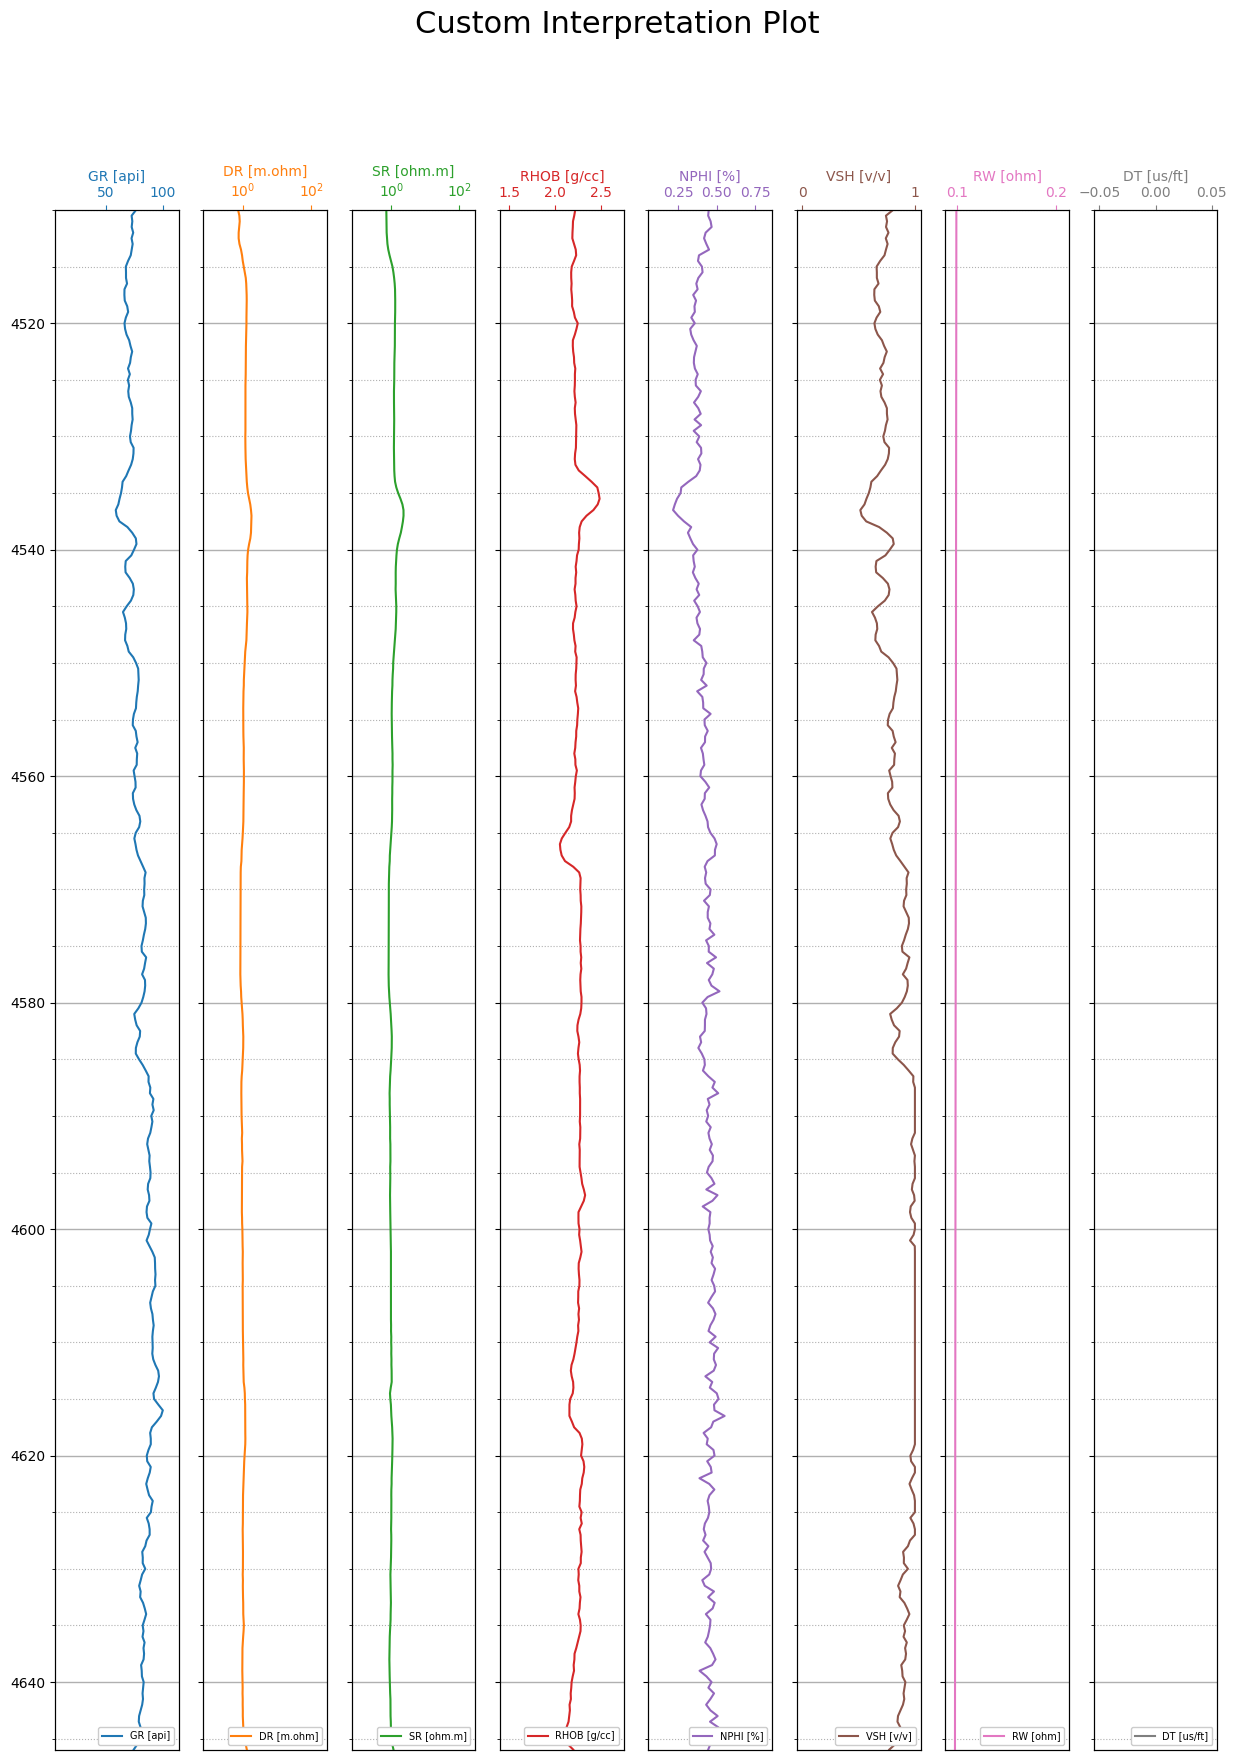

In [15]:
custom_logs = ["GR", "DR", "SR", "RHOB", "NPHI", "VSH", "RW", "DT"]
units = ["api", "m.ohm", "ohm.m", "g/cc", "%", "v/v", "ohm", "us/ft"]

custom_interpretation_plot(calculation_data, depth_start, depth_end, custom_logs, units)

## **6. CLAY VOLUME CALCULATION**
### **6.1. Single Method with Gamma Ray Log**

#### **The calculation of the volume of clay is carried out using five equation options, namely:**

**Linear Gamma Ray Equation:**
- *Formula:* $ VCL_{gr}=I_{gr} = \frac{gr_{log}-gr_{clean}}{gr_{clay}-gr_{clean}}$
- *Explanation:* Calculates the Volume of Clay $VCL_{gr}$ based on gamma ray log $gr_{log}$, clean sand gamma ray $gr_{clean}$, and clay gamma ray $gr_{clay}$.

**Larionov (Tertiary/Young Rocks) Equation:**
- *Formula:* $ VCL_{gr} = 0.083(2^{3.7*I_{gr}}-1)$
- *Explanation:* Specifically designed for tertiary/young rocks, using the gamma ray index $I_{gr}$.

**Larionov (Old Rocks) Equation:**
- *Formula:* $ VCL_{gr} = 0.33(2^{2\times I_{gr}}-1)$
- *Explanation* Tailored for old rocks, also utilizing the gamma ray index $I_{gr}$

**Clavier Equation:**
- *Formula:* $ VCL_{gr} = 1.7 - (3.38-(I_{gr}+0.7)^2)^{\frac{1}{2}} $
- *Explanation:* Involves a square root term and is based on the gamma ray index $I_{gr}$.

**Steiber Equation:**
- *Formula:* $ VCL_{gr} = 0.5(\frac{I_{gr}}{1.5-I_{gr}})$
- *Explanation:* Includes a ratio of the gamma ray index $I_{gr}$.

In [16]:
def vclgr(gr_log, gr_clean, gr_clay, correction=None):

    igr=(gr_log-gr_clean)/(gr_clay-gr_clean)
    vclgr_larionov_young=0.083*(2**(3.7*igr)-1)
    vclgr_larionov_old=0.33*(2**(2*igr)-1)
    vclgr_clavier=1.7-(3.38-(igr+0.7)**2)**0.5
    vclgr_steiber=0.5*igr/(1.5-igr)

    if correction == "young":
        vclgr=vclgr_larionov_young
    elif correction == "older":
        vclgr=vclgr_larionov_old
    elif correction=="clavier":
        vclgr=vclgr_clavier
    elif correction=="steiber":
        vclgr=vclgr_steiber
    else:
        vclgr=igr
    return vclgr

### **6.2. Single Method with Spontaneous Potential Log:**

The volume of clay $VCL_{sp}$ can be determined using the Spontaneous Potential (SP) log with the following equation:

$$VCL_{sp} = \frac{sp_{log} - sp_{clean}}{sp_{clay} - sp_{clean}}$$

- **Formula Explanation:**
  - $VCL_{sp}$: Volume of Clay using Spontaneous Potential.
  - $sp_{log}$: Spontaneous Potential log value.
  - $sp_{clean}$: SP value in clean formations.
  - $sp_{clay}$: SP value in clay-rich formations.

This equation provides a method for estimating the volume of clay based on the SP log measurements, where the SP log is compared to clean and clay values.


In [17]:
def vclsp(sp_log, sp_clean, sp_clay):
    vclsp=(sp_log-sp_clean)/(sp_clay-sp_clean)
    return vclsp

### **6.3. Single Method with Resistivity Log:**

The volume of clay $V_{rt}$ can be calculated using the Resistivity (RT) log with the following equation:

$$V_{rt} = \frac{rt_{clay}}{rt_{log}} \times \frac{rt_{clean} - rt_{log}}{rt_{clean} - rt_{clay}}$$

- **Formula Explanation:**
  - $V_{rt}$: Volume of Clay using Resistivity log.
  - $rt_{clay}$: Resistivity in clay-rich formations.
  - $rt_{log}$: Resistivity log value.
  - $rt_{clean}$: Resistivity in clean formations.
  - $st_{clay}$: Saturation in clay-rich formations.

If $rt_{log} > 2 \times rt_{clay}$, then the volume of clay $VCL_{rt}$ is calculated as follows:

$$VCL_{rt} = 0.5(2 \times V_{rt})^{(0.67(V_{rt} + 1))}$$

- **Condition Explanation:**
  - $rt_{log}$ greater than twice $rt_{clay}$ triggers the second part of the calculation.

This method provides a way to estimate the volume of clay based on the Resistivity log, with a condition for specific scenarios where $rt_{log}$ exceeds a threshold relative to $rt_{clay}$.


In [18]:
def vclrt(rt_log, rt_clean, rt_clay):
    vrt = np.where( (rt_log == 0) | (rt_clean == rt_clay),
      np.nan,
      (rt_clay/rt_log)*(rt_clean-rt_log)/(rt_clean-rt_clay)
    )

    vclrt = np.where(rt_log > 2* rt_clay,
        0.5 * (2 * vrt)** (0.67*(vrt+1)),
        vrt
    )
    return vclrt

### **6.4. Dual Method with N-D Crossplot**
Dual methods involve the utilization of neutron-density crossplots, which are based on the correlation between neutron and density measurements. These crossplots depict the identification of a 'clean line' and a 'clay point,' as illustrated in the accompanying graphs.
1. Clean Line: The clean line on the neutron-density crossplot typically represents a linear trend that corresponds to rocks with minimal clay content. Rocks along this line have a consistent ratio of neutron and density measurements. This could correspond to sandstones or other clean, mineral-rich formations.

2. Clay Point: The clay point is a marker on the crossplot that corresponds to clay-rich formations. These formations will exhibit different neutron and density measurements compared to the clean line due to their higher clay content.

The terms **term1** and **term2** are defined as follows:

$$
\text{term1} = (\rho_{\text{clean2}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{log}} - \text{neut}_{\text{clean1}}) - (\rho_{\text{log}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clean2}} - \text{neut}_{\text{clean1}})
$$

$$
\text{term2} = (\rho_{\text{clean2}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clay}} - \text{neut}_{\text{clean1}}) - (\rho_{\text{clay}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clean2}} - \text{neut}_{\text{clean1}})
$$

The volume of clay and neutron-density (\(VCL_{nd}\)) is then calculated as:

$$
VCL_{nd} = \frac{\text{term1}}{\text{term2}}
$$

- **Variables Explanation:**
  - $\rho_{\text{clean1}}$, $\rho_{\text{clean2}}$: Density values in clean formations.
  - $\rho_{\text{log}}$: Density log value.
  - $\text{neut}_{\text{clean1}}$, $\text{neut}_{\text{clean2}}$: Neutron-density values in clean formations.
  - $\text{neut}_{\text{log}}$: Neutron-density log value.
  - $\text{neut}_{\text{clay}}$: Neutron-density value in clay-rich formations.


This equation provides a method for calculating the volume of clay and neutron-density based on a neutron-density crossplot with density and neutron-density log measurements and values in clean formations.


In [19]:
def vclnd(neut_log,den_log,neut_clean1,den_clean1,neut_clean2,den_clean2,neut_clay,den_clay):
    term1 = (den_clean2-den_clean1)*(neut_log-neut_clean1)-(den_log-den_clean1)*(neut_clean2-neut_clean1)
    term2 =(den_clean2-den_clean1)*(neut_clay-neut_clean1)-(den_clay-den_clean1)*(neut_clean2-neut_clean1)
    vclnd = term1/term2
    return vclnd

### **6.5. Display for Traject and Histogram (GR and SP), N-D Crossplot, and VCL**
Several displays will be generated, including GR, SP vs. DEPTH track, histograms, neutron-density crossplot, and VCL track. These displays serve the purpose of observing and selecting the suitable parameters for distinguishing between clay-rich and clean formations. Additionally, they will allow for a comparison of the outcomes obtained from the various VCL calculation methods mentioned previously.

#### **6.5.1. VCL Plot Function** <br>

In [20]:
def vcl_plot(logs, depth_start, depth_end, gr_clean=None, gr_clay=None,
             neut_clean1=None, den_clean1=None, neut_clean2=None,
             den_clean2=None, neut_clay=None, den_clay=None,
             sp_clean=None, sp_clay=None, rhob_axis=[1.5,2.8], nphi_axis=[0,1]):
    """
    Plot volume of clay from different methods with handling for missing data

    Parameters:
    -----------
    logs : pandas DataFrame
        Well log data containing depth and measurement curves
    depth_start, depth_end : float
        Depth range for plotting
    *_clean, *_clay : float, optional
        Clean and clay points for different methods
    """
    # filter the well depths:
    well_data = logs[(logs['DEPT'] >= depth_start) & (logs['DEPT'] <= depth_end)]

    # Create figure and gridspec
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle('Volume of clay from different methods', fontsize=14)
    fig.subplots_adjust(top=0.90, wspace=0.3, hspace=0.3)

    gs = gridspec.GridSpec(3, 3)

    # Initialize subplots
    ax1 = fig.add_subplot(gs[:, 0])  # All rows, column 1
    ax2 = fig.add_subplot(gs[0, 1])  # Row 1, column 2a
    ax3 = fig.add_subplot(gs[1, 1])  # Row 2, column 2b
    ax4 = fig.add_subplot(gs[2, 1])  # Row 3, column 2c
    ax5 = fig.add_subplot(gs[:, 2])  # Row all rows, column 3

    # Check for depth column
    depth_col = next((col for col in ['DEPT', 'DEPTH', 'MD'] if col in logs.columns), None)
    if depth_col is None:
        raise ValueError("No depth column found in logs")

    # Plot GR and SP (if available)
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_ylim(depth_start, depth_end)
    ax1.set_ylabel('DEPTH')

    if 'GR' in well_data.columns:
        ax1.plot(well_data.GR, well_data[depth_col], color='green')
        ax1.set_xlabel('GR [api]', color='green')

    if 'SP' in logs.columns:
        ax12 = ax1.twiny()
        ax12.plot(well_data.SP, well_data[depth_col], color='blue')
        ax12.set_xlabel("SP [mV]", color='blue')

    if 'DR' in logs.columns:
        ax13 = ax1.twiny()
        ax13.set_xscale('log')
        ax13.plot(well_data.DR, well_data[depth_col], color='purple')
        ax13.set_xlabel('RT [ohm]', color='purple')

    # Histograms
    curves_to_plot = {
        'GR': ('green', ax2, 'linear', 'GR [api]'),
        # 'SP': ('blue', ax3, 'SP [mV]'),
        'DR': ('gray', ax3, 'log', 'DR [m.ohm]')
    }

    for curve, (color, ax, scale, xlabel) in curves_to_plot.items():
        if curve in well_data.columns:
            ax.hist(well_data[curve].dropna(), bins=15, color=color)
            ax.set_xscale(scale)
            ax.set_xlabel(xlabel)
            ax.set_ylabel('Frequency')

    # N-D Crossplot (if both NPHI and RHOB are available)
    if all(curve in well_data.columns for curve in ['NPHI', 'RHOB']):
        points = ax4.scatter(well_data.NPHI, well_data.RHOB,
                           c=well_data.GR if 'GR' in well_data.columns else 'blue',
                           s=5, cmap="viridis")
        cbar = plt.colorbar(points)
        cbar.set_label('GR [API]', rotation=90, size=5)
        ax4.set_xlabel('NPHI [%]')
        ax4.set_ylabel('RHOB [g/cc]')
        ax4.invert_yaxis()
        ax4.invert_xaxis()
        ax4.grid(True)

        # Add axis limits (set constraints here)
        ax4.set_xlim(nphi_axis)  # Example for NPHI, adjust based on your data
        ax4.set_ylim(rhob_axis)

        # Plot clean and clay points if provided
        if all(v is not None for v in [neut_clean1, den_clean1, neut_clean2, den_clean2]):
            ax4.plot([neut_clean1, neut_clean2], [den_clean1, den_clean2],
                    marker='o', color='black', linewidth=1)
            ax4.text(neut_clean1, den_clean1, 'clean point 1', fontsize=6,
                    bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))
            ax4.text(neut_clean2, den_clean2, 'clean point 2', fontsize=6,
                    bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))

        if neut_clay is not None and den_clay is not None:
            ax4.plot(neut_clay, den_clay, 'ro', color='black', linewidth=1)
            ax4.text(neut_clay, den_clay, 'clay point', fontsize=6,
                    bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))

    # Plot VCL values
    vcl_curves = {
        'VCLGR': ('green', 'VCLGR'),
        'VCLND': ('red', 'VCLND'),
        'VCLSP': ('blue', 'VCLSP'),
        'VCLRT': ('purple', 'VCLRT')
    }

    for curve, (color, label) in vcl_curves.items():
        if curve in logs.columns:
            ax5.plot(logs[curve], logs[depth_col], label=label, color=color)

    ax5.legend(loc='best', fontsize='x-small')
    ax5.set_xlim(0, 1)
    ax5.set_ylim(depth_start, depth_end)
    ax5.invert_yaxis()
    ax5.grid(True)
    ax5.set_xlabel('VCL [v.v]')

    # return fig

## **Define Logs variable for Calculations**

In [21]:
logs=calculation_data.copy()

In [22]:
logs.columns

Index(['WELL', 'DEPT', 'GR', 'DR', 'SR', 'NPHI', 'RHOB', 'DT', 'VSH', 'RW',
       'core_por', 'core_perm'],
      dtype='object')

### **6.6. Clay Volume Calcultion Function**

#### **6.6.1. Define the Clean and Clay Paramater**
- Minimum (clean) and maximum (clay) values of GR for both
- Minimum (clean) and maximum (clay) values of SP for both
- Minimum (clean) and maximum (clay) values of RT for both

To start with, simply guess any numbers. Then, refer to the crossplot results in section 5.5.3

In [23]:
# Clean point 1 (typical for a dense, clean rock like limestone)
neut_clean1 = 0.04
den_clean1 = 2.65

# Clean point 2 (moderate porosity, consolidated formation)
neut_clean2 = 0.38
den_clean2 = 1.9

# Clay point (high density, low porosity)
neut_clay = 0.7
den_clay = 2.2

#sand and shale baseline
gr_clean = 40
gr_clay = 110
rt_clean = 1.8
rt_clay = 0.6

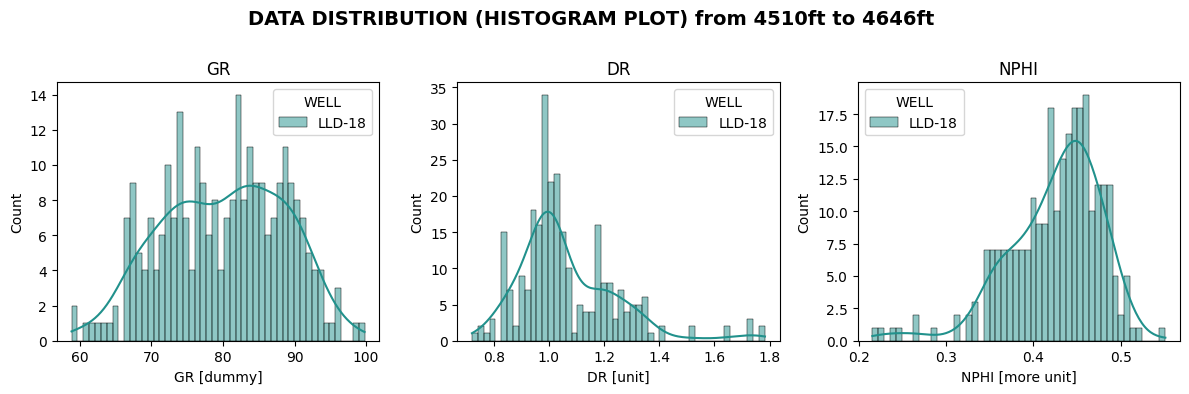

In [24]:
columns_list = ["GR", "DR", "NPHI"]
the_units = ["dummy", "unit", "more unit"]

histplot(logs, columns_list, the_units, depth_start=4510, depth_end=4646)

#### **6.6.2. Do the Clay Volume Calculation**

In [25]:
logs['VCLGR'] = vclgr(logs.GR, gr_clean, gr_clay, correction="older")
logs['VCLRT'] = vclrt(logs.DR, rt_clean, rt_clay)
logs['VCLND'] = vclnd(logs.NPHI, logs.RHOB, neut_clean1, den_clean1, neut_clean2, den_clean2, neut_clay, den_clay)

C:\Users\ARF\AppData\Local\Temp\ipykernel_24236\3416398203.py:8: RuntimeWarning: invalid value encountered in power
  0.5 * (2 * vrt)** (0.67*(vrt+1)),


#### **6.6.3. Extract and revise the clean and clay parameter from the Neutron-Density Crossplot**

- Define the clean line and clay point. This is done for VCL (Volume of Clay) calculations using the Neutron Density Crossplot.
- After that, return to 5.6.1 if the clean line and clay point are considered inaccurate on the plot

C:\Users\ARF\AppData\Local\Temp\ipykernel_24236\2998586346.py:101: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax4.plot(neut_clay, den_clay, 'ro', color='black', linewidth=1)


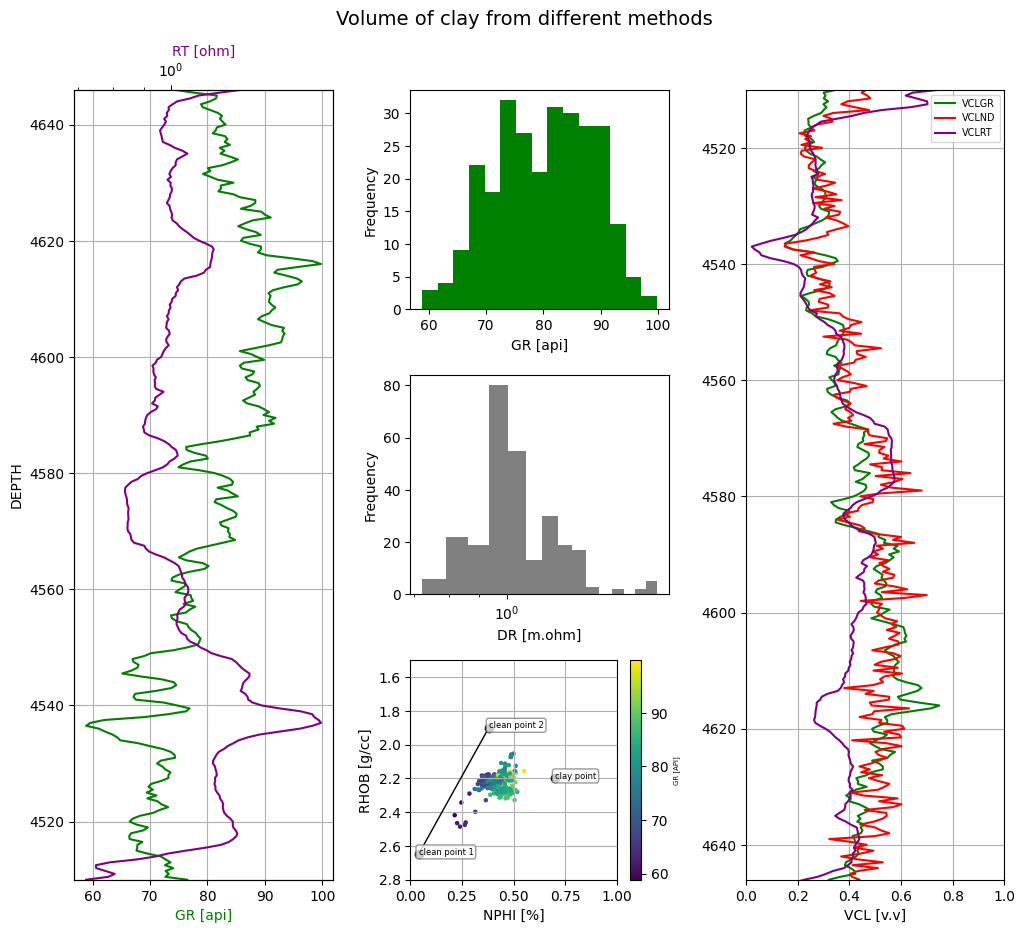

In [26]:
vcl_plot(
    logs,
    depth_start,
    depth_end,
    gr_clean,
    gr_clay,
    neut_clean1,
    den_clean1,
    neut_clean2,
    den_clean2,
    neut_clay,
    den_clay,
    rhob_axis=[2.8, 1.5],
    nphi_axis=[0,1]
    )

### **6.7 Choose the Best VCL**

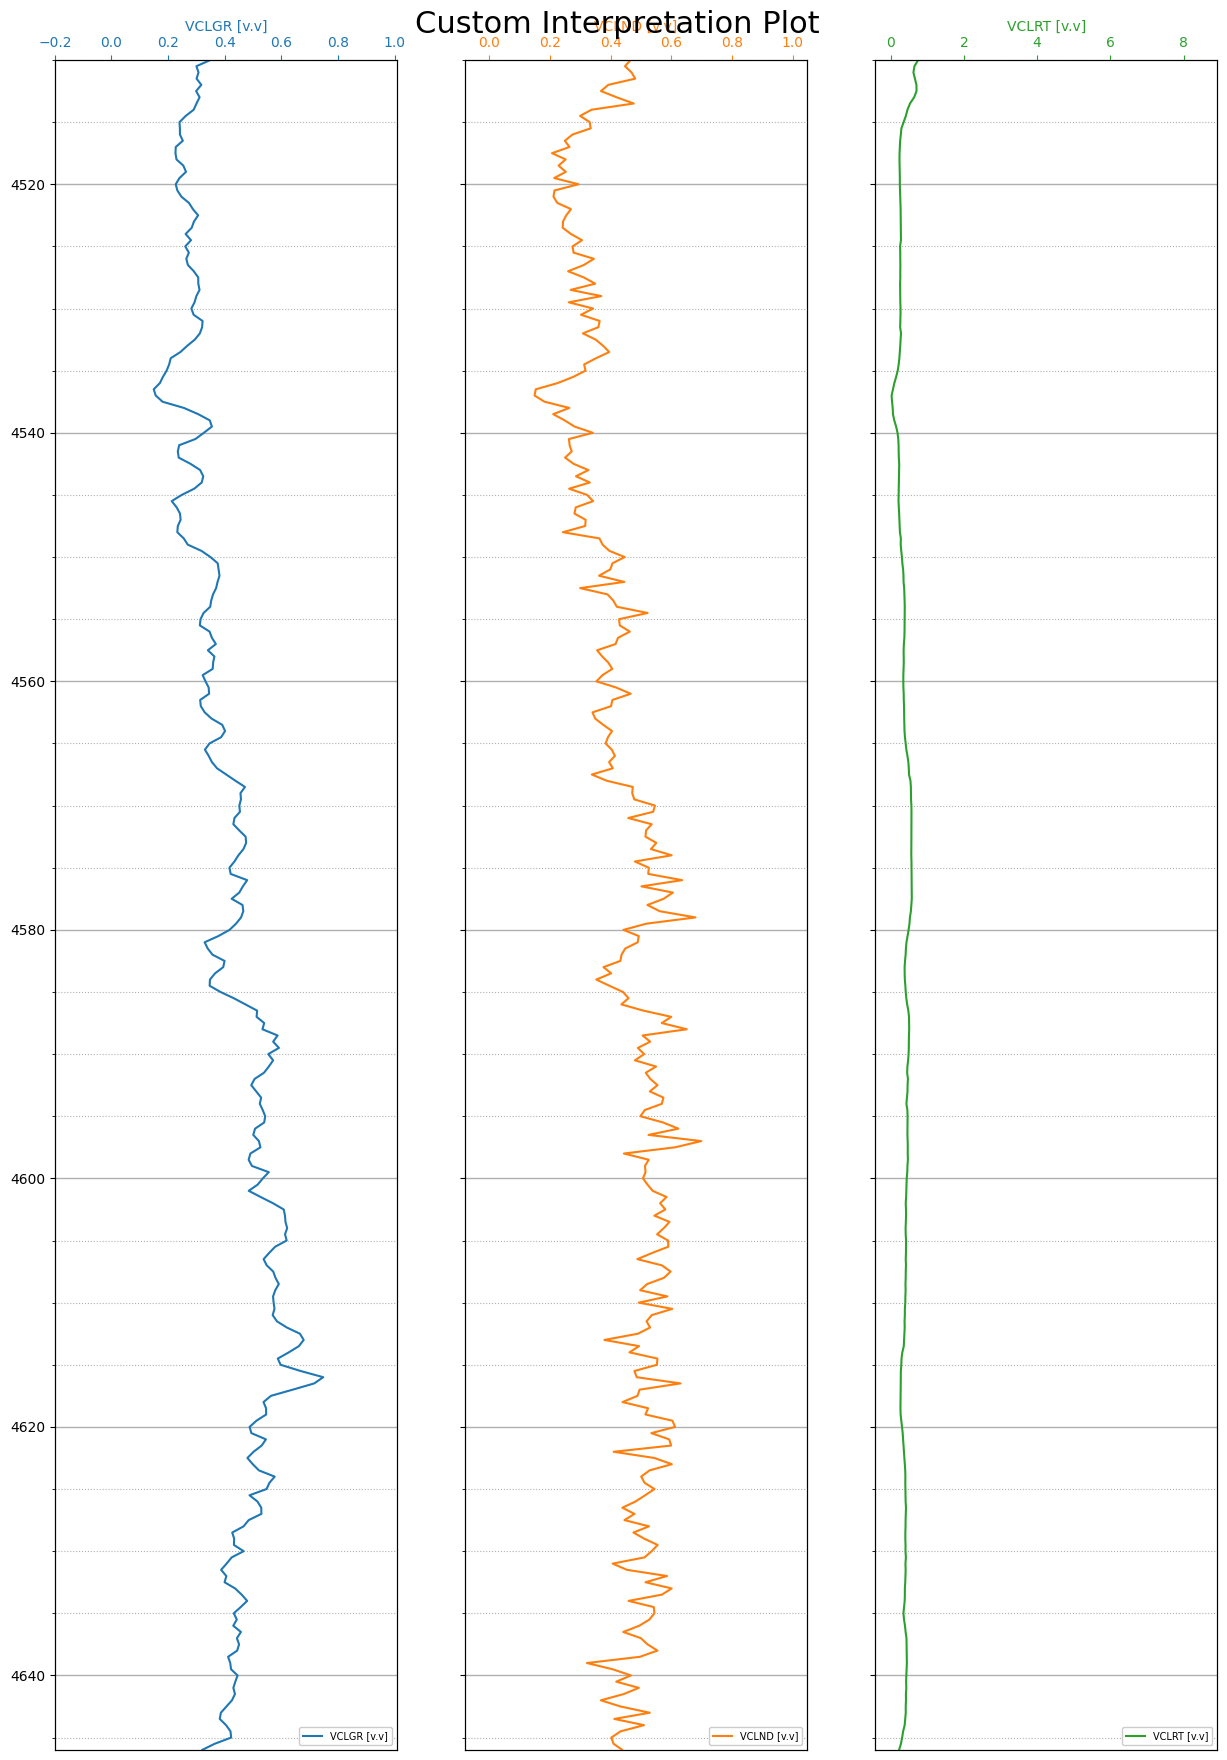

In [27]:
custom_interpretation_plot(logs, depth_start, depth_end, custom_logs=["VCLGR", "VCLND", "VCLRT"], units=["v.v", "v.v", "v.v"])

To make the understanding easier, we will treat VCLGR as equivalent to VCL.
Alternatively, from 2 sub plot above, we can view vcl as the smallest value derived from various techniques, where VCL equals the minimum among VCLGR, VCLSP, and VCLND.

In [28]:
logs['VCL']=logs['VCLGR']

## **7. POROSITY CALCULATION**
There are three types of logs that can be used to estimate porosity: sonic, density, and neutron logs. Porosity can be determined using either individual or paired combinations of these logs. The possible combinations include neutron-density, neutron-sonic, and sonic-density.<br>
**Basic porosity formulas are:**
- Sonic:
    - Wyllie (Time Average)
    - Raymer-Hunt-Gardner
- Density
- Neutronic<br>

### **7.1. Shale Porosity Equation**
**Shale porosity with sonic Log:** <br>
$\phi_{shale[sonic]} = \frac{\Delta T_{sh}-\Delta T_{ma}}{\Delta T_{fl}-\Delta T_{ma}}$

**Shale porosity with density log:** <br>
$\phi_{shale[density]} = \frac{\rho _{sh}-\rho _{ma}}{\rho _{fl}-\rho _{ma}}$

*Formula Explanation:*
- $\phi_{shale[sonic]}$: Shale porosity with sonic Log.
- $\phi_{shale[density]}$: Shale porosity with density log.
- $\Delta T_{sh}$: Sonic transit time in shale.
- $\Delta T_{ma}$: Sonic transit time in matrix.
- $\Delta T_{fl}$: Sonic transit time in fluid.
- $\rho _{sh}$: Density in shale.
- $\rho _{ma}$: Density in matrix.
- $\rho _{fl}$: Density in fluid.

In [29]:
#Willie-TimeAverage
def phis_shale(dt_sh, dt_ma, dt_fl):
    phis_shale = (dt_sh-dt_ma)/(dt_fl-dt_ma)
    return phis_shale

In [30]:
def phid_shale(den_sh, den_ma, den_fl):
    phid_shale = (den_sh - den_ma) / (den_fl - den_ma)
    return phid_shale

### **7.2. Wyllie Time-Average Equation**
**Porosity in the part under review:** <br>
$\phi_{[sonic][Wyllie]} = \frac{1}{cp}\times \frac{\Delta T_{log}-\Delta T_{ma}}{\Delta T_{fl}-\Delta T_{ma}}$

**Effective porosity:** <br>
$\phi_{corr[sonic][Wyllie]} = {\phi_{[sonic][Wyllie]}}-{v_{cl}\times\phi_{shale[sonic]}}$

*Formula Explanation:*
- $\phi_{[sonic][Wyllie]}$: Porosity in the part under review using Wyllie Time-Average equation.
- $\phi_{corr[sonic][Wyllie]}$: Effective porosity considering volume of clay.

In [31]:
def phis_w(dt_log, dt_ma, dt_fl, cp):
    phis_w=(1/cp)*(dt_log-dt_ma)/(dt_fl-dt_ma)
    return phis_w

In [32]:
def phis_w_sh_corr(dt_log, dt_ma, dt_fl, cp, dt_sh, vcl):
    phis_w_sh_corr = phis_w(dt_log,dt_ma,dt_fl,cp) - vcl*phis_shale(dt_sh,dt_ma,dt_fl)
    return phis_w_sh_corr

### **7.3. Raymer Hunt Gardner Equation**
**Porosity in the part under review:** <br>
$\phi_{[sonic][Raymer]} = \alpha\times \frac{\Delta T_{log}-\Delta T_{ma}}{\Delta T_{log}}$

**Effective porosity:** <br>
$\phi_{corr[sonic][raymer]} = {\phi_{[sonic][raymer]}}-{v_{cl}\times\phi_{shale[sonic]}}$

*Formula Explanation:*
- $\phi_{[sonic][Raymer]}$: Porosity in the part under review using Raymer Hunt Gardner equation.
- $\phi_{corr[sonic][raymer]}$: Effective porosity considering volume of clay.

In [33]:
#Raymer-Hunt-Gardner (the alpha(5/8) ranges from 0.625-0.70, 0.67-most, 0.60-gas reservoirs)
def phis_rhg(dt_log, dt_ma, alpha):
    phis_rhg=(alpha)*(dt_log-dt_ma)/(dt_log)
    return phis_rhg

In [34]:
def phis_rhg_sh_corr(dt_log, dt_ma, dt_sh, vcl,alpha,dt_fl):
    phis_rhg_sh_corr = phis_rhg(dt_log, dt_ma, alpha) - vcl * phis_shale(dt_sh, dt_ma, dt_fl)
    return phis_rhg_sh_corr

### **7.4. Density Equation**
**Porosity in the part under review:** <br>
$\phi_{[density]} = \frac{\rho_{log}-\rho_{ma}}{\rho_{fl}-\rho_{ma}}$

**Effective porosity:** <br>
$\phi_{corr[density]} = {\phi_{[density]}}-{v_{cl}\times\phi_{shale[density]}}$

*Formula Explanation:*
- $\phi_{[density]}$: Porosity in the part under review using density log.
- $\phi_{corr[density]}$: Effective porosity considering volume of clay.

In [35]:
#Density
def phid(rho_log, rho_m, rho_f, new=True):
    if new:
      phid = (rho_m - rho_log)/(rho_m - rho_f)
    else:
      phid = (rho_log - rho_m) / (rho_f - rho_m)
    return phid

def phi_simandoux(vsh, phid):
  base_eq = (vsh**2)+(phid**2)
  phi = np.sqrt(base_eq/2)

  return phi

In [36]:
def phid_sh_corr(den_log, den_ma, den_fl, den_sh, vcl):
    phid_sh_corr = phid(den_log, den_ma, den_fl) - vcl * phid_shale(den_sh, den_ma, den_fl)
    return phid_sh_corr

### **7.5. Neutron Equation**
**Effective porosity:** <br>
$\phi_{[corr][neutron]} = \frac{nphi_{log}-vcl\times nphi_{shale}}{100}$

*Formula Explanation:*
- $\phi_{[corr][neutron]}$: Effective porosity using neutron log.
- $nphi_{log}$: Neutron porosity log value.
- $vcl$: Volume of clay.

In [37]:
# Neutron
def phin_sh_corr(neut, neut_sh, vcl):
    phin_sh_corr = (neut-vcl*neut_sh)/100
    return phin_sh_corr

### **7.6. Neutron-Density Equation**
$\phi_{[neutronxdensity]} = \frac{\phi_{nshc} + \phi_{dshc}}{2}$

$\phi_{[corr][neutronxdensity]} = \sqrt{\frac{\phi_{n}^2 + \phi_{d}^2}{2}}$

*Formula Explanation:*
- $\phi_{[neutronxdensity]}$: Porosity using neutron-density combination.
- $\phi_{[corr][neutronxdensity]}$: Effective porosity considering neutron-density combination.
- $\phi_{nshc}$, $\phi_{dshc}$: Neutron and density porosities in shale and clean formations.
- $\phi_{n}$, $\phi_{d}$: Neutron and density porosities.

In [38]:
#Neutron-Density
def phixnd(phinshc, phidshc):
    phixnd= (phinshc + phidshc) / 2
    return phixnd
def phixnd_gas_corr(phin, phid, phin_sh, phid_sh):
    phixnd_gas_corr= ((phin**2+phid**2)/2)**(0.5)    #for gas intervals (nphi<dphi = crossover)
    return phixnd_gas_corr

### **7.7. Resistivity Equation**
**7.7.1. Volume of Clay using Resistivity log:** <br>
$V_{rt} = \frac{rt_{clay}}{rt_{log}} \times \frac{rt_{clean} - rt_{log}}{rt_{clean} - rt_{clay}}$

- **Formula Explanation:**
  - $V_{rt}$: Volume of Clay using Resistivity log.
  - $rt_{clay}$: Resistivity in clay-rich formations.
  - $rt_{log}$: Resistivity log value.
  - $rt_{clean}$: Resistivity in clean formations.
  - $st_{clay}$: Saturation in clay-rich formations.

### **7.7. Define the Parameter for Porosity Calculation**


In [39]:
#Matrix, fluid and appropiate shales values must be declared in the next variables:
dt_ma, dt_fl, dt_sh, cp, alpha = 55.5, 188.0, 90.0, 1, 5/8
den_ma = 2.65
den_fl = 0.1
den_sh = den_clay

phis_sh=phis_shale(dt_sh, dt_ma, dt_fl)
phid_sh=phis_shale(den_sh, den_ma, den_fl)
phin_sh=45

### **7.8. All Porosity Calculation**


In [40]:
# # 1. Poro calc with DT
logs['PHISw']=phis_w(logs.DT, dt_ma, dt_fl, cp)
logs['PHISwshc']=phis_w_sh_corr(logs.DT, dt_ma, dt_fl, cp, dt_sh, logs.VCL).clip(0,1)

logs['PHISrhg']=phis_rhg(logs.DT, dt_ma, alpha)
logs['PHISrhgshc']=phis_rhg_sh_corr(logs.DT, dt_ma, dt_sh, logs.VCL,alpha,dt_fl).clip(0,1)

# # 2. Poro calc with RHOB
logs['PHID']=phid(logs.RHOB, den_ma, den_fl, new=True)
logs['PHIDshc']=phid_sh_corr(logs.RHOB, den_ma, den_fl, den_sh, logs.VCL).clip(0,1)

# # 3. Poro calc for Simandoux using VSH param
logs['PHI_SIMANDOUX']=phi_simandoux(logs.VSH,logs.PHID).clip(0,1)

# # 4. Poro calc with NPHIN (Dual-method)
logs['PHIN']=(logs.NPHI/100).clip(0,1)
logs['PHINshc']=phin_sh_corr(logs.NPHI, phin_sh, logs.VCL).clip(0,1)

logs['PHIxND']=phixnd(logs.PHINshc,logs.PHIDshc).clip(0,1)

### **7.9 Choose the Best PHIE**

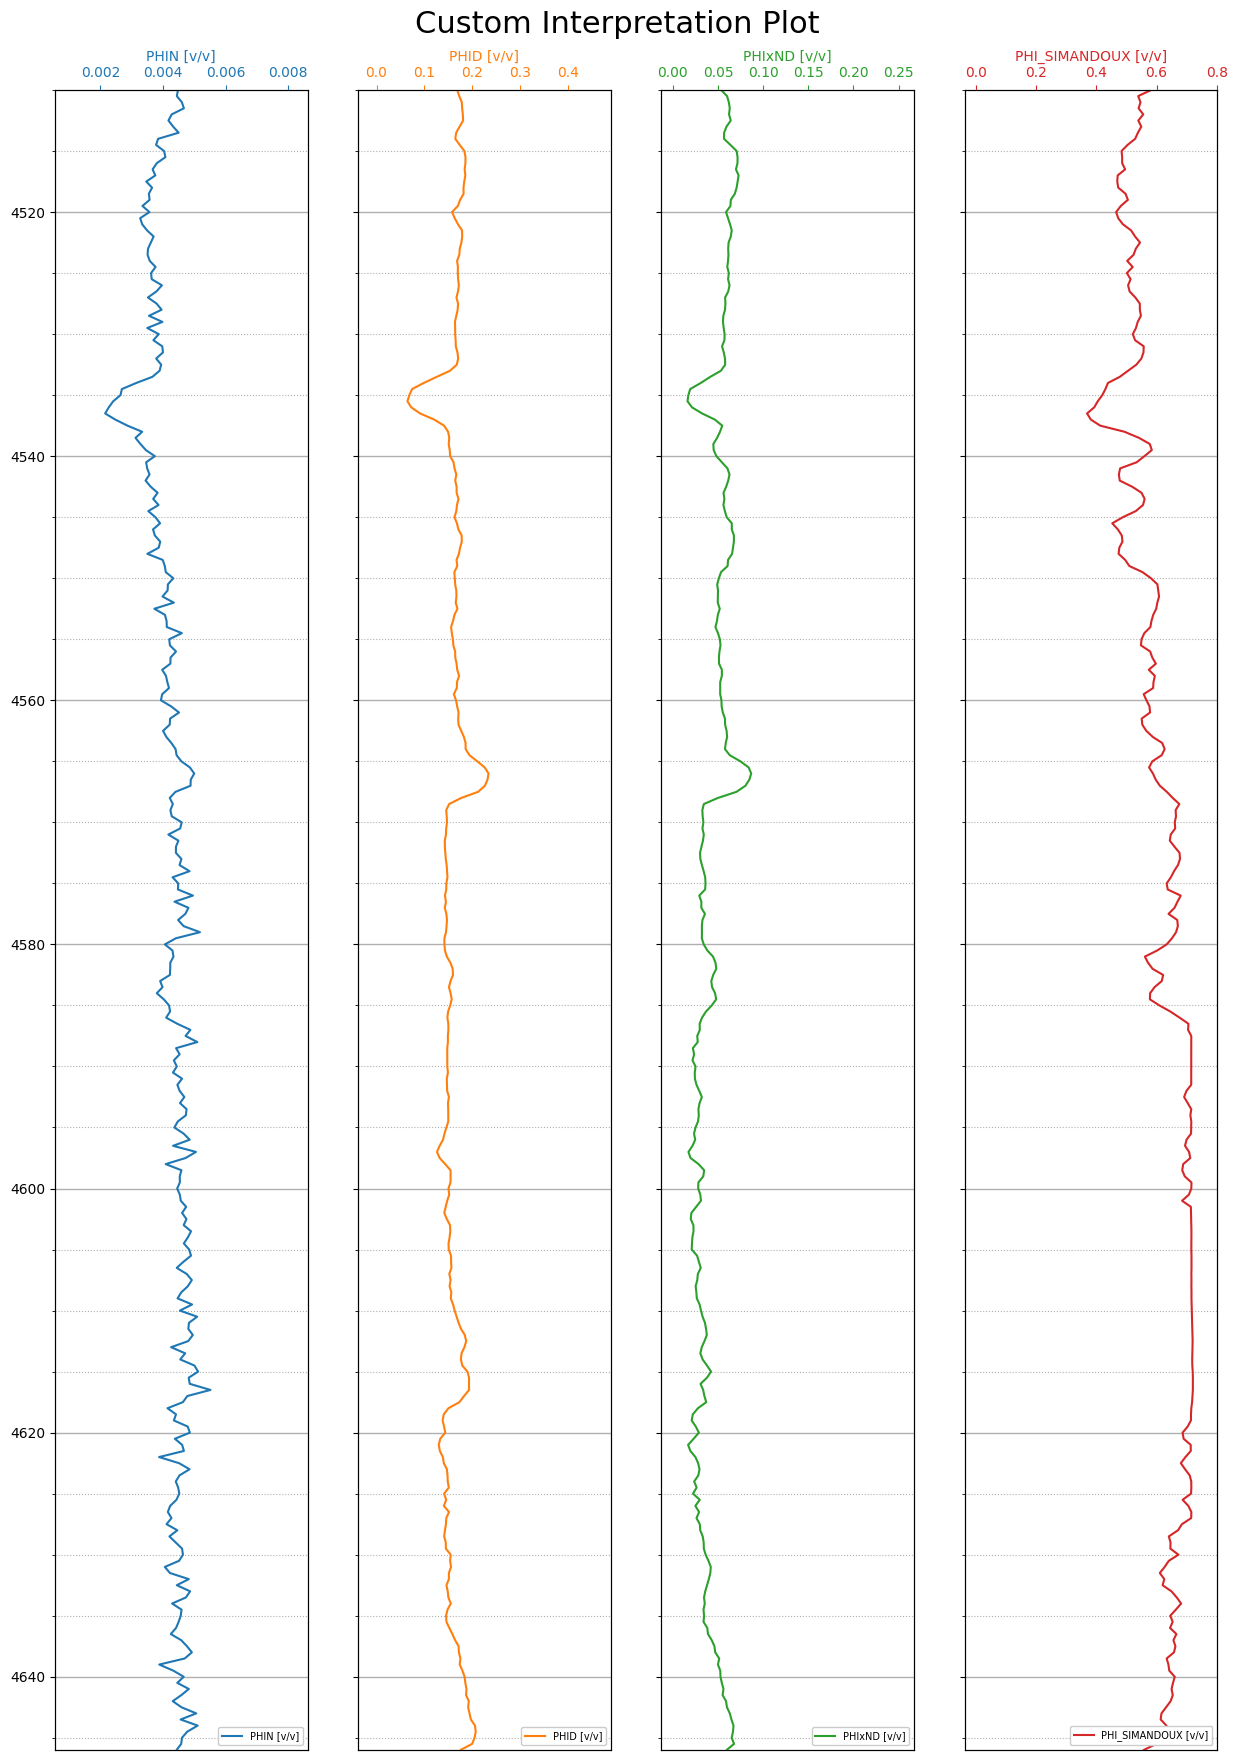

In [41]:
# Example usage:
custom_interpretation_plot(logs, depth_start, depth_end, custom_logs=["PHIN", "PHID", "PHIxND", "PHI_SIMANDOUX"], units=["v/v", "v/v", "v/v", "v/v"])

In [42]:
# Choosing the best porosity calc for SW (waxman, indonesia, archie) calc later on this code
logs['PHIE']=logs['PHIxND']

## **8. WATER SATURATION CALCULATION**
Before calculating the water saturation will need a value for the Rw (Resistivity of water)<br>
**Resistivity of water:**
It can be determined from:
- Ater catalogs <br>
- DST test water analysis <br>
- Rw from SP (needs information about Rmud and ... ) <br>
- Rwa Method (Rw from a 100% water zone) <br>

### **8.1. Archie Water Sturation Equation**
Suppose we lack any prior knowledge of Rwater. In such cases, following the best approach involves utilizing a PICKETT graph. This graph takes on a logarithmic form derived from Archie's equation:

$Sw^{n} = \frac{a \times R_w}{R_t \times \phi^m}$

In [43]:
def sw_archie(Rw, Rt, Poro, a, m, n):
        F = a / (Poro**m)
        Sw_archie = (F * Rw/Rt)**(1/n)
        return Sw_archie

The equation can be transformed into a logarithmic expression and visualized on a log plot of RT against PHI:

$\log \phi = -\frac{1}{m} \log(R_t) - n \log(S_w) + \log(a\times R_w)$

In [44]:
def pickett_plot(logs, depth_start, depth_end, x_range, y_range, vcl_limit, a, rwa, m, n, z):
    """
    Creates a Pickett Plot using Altair with tooltips and saturation lines.

    Args:
        logs (pd.DataFrame): DataFrame containing log data (DEPT, DR, PHIE, VCL, z).
        depth_start (float): Starting depth.
        depth_end (float): Ending depth.
        x_range (list): x axis plot range
        y_range (list): y axis plot range
        vcl_limit (float): Volume of clay limit.
        a (float): Tortuosity factor.
        rwa (float): Water resistivity.
        m (float): Cementation exponent.
        n (float): Saturation exponent.
        z (str): Column name for color encoding (e.g., 'VSH').

    Returns:
        alt.Chart: Altair chart object.
    """

    filtered_logs = logs[(logs.DEPT >= depth_start) & (logs.DEPT <= depth_end) & (logs.VCL < vcl_limit)].copy()

    scatter = alt.Chart(filtered_logs).mark_circle(size=60).encode(
        x=alt.X('DR:Q', scale=alt.Scale(type='log', domain=x_range), title='DR [m.ohm]'),
        y=alt.Y('PHIE:Q', scale=alt.Scale(type='log', domain=y_range), title='PHIE [v/v]'),
        color=alt.Color(f'{z}:Q', scale=alt.Scale(scheme='plasma'), title=z),
        tooltip=['DEPT', 'DR', 'PHIE', z]
    ).properties(
        title=f'Pickett Plot and Rw = {rwa} ohm.m',
        width=400,
        height=400  # Increase height
    )

    sw_plot = (1.0, 0.8, 0.6, 0.4, 0.2)
    phie_plot = (0.01, 1)
    rt_plot = {}

    for sw in sw_plot:
        rt_values = []
        for phie in phie_plot:
            rt_result = (a * rwa) / (sw ** n) / (phie ** m)
            rt_values.append(rt_result)
        rt_plot[f'SW {int(sw * 100)}%'] = rt_values

    lines = []
    for i, (label, rt_values) in enumerate(rt_plot.items()):
        line_data = pd.DataFrame({'DR': rt_values, 'PHIE': phie_plot, 'SW': label})
        line = alt.Chart(line_data).mark_line(opacity=0.4).encode(
            x='DR:Q',
            y='PHIE:Q',
            color=alt.value('grey'),
            strokeDash=alt.value([5, 5])
        ).transform_calculate(
            SW_label = f"'{label}'"
        ).properties(
            title = f"{label}"
        )
        dy_offset = -10 *(1 if i % 2 != 0 else -1) - 25 #adjust dy based on index
        text = alt.Chart(line_data.iloc[[0]]).mark_text(
            align='left',
            baseline='middle',
            dx=-20,
            dy = dy_offset
        ).encode(
            x='DR:Q',
            y='PHIE:Q',
            text = alt.value(label),
            color = alt.value("green")
        )

        lines.append(line + text)

    combined_lines = alt.layer(*lines)

    return scatter + combined_lines

#### **8.1.1. Define the Paramater for Archie Water Saturation Calculation**

Firstly, it's important to establish the values for the variables: a, m, and n. To initiate this process, you might consider beginning with the values (a=1, m=2, n=2), which tend to yield favorable results across various rock types. In cases where the rock matrix contains a mixture of shale, it might be advisable to reduce the value of m to 1.8.
- a, turtuosity factor
- m, cementation factor
- n, saturation exponent
- rwa, water resistivity
- vcl_limit, volume of clay upper limit for selction of data for graph

In [45]:
a = 0.9
m = 1
n = 1.8

rw_input = 0.06

In [46]:
logs_archie = logs.copy()

#### **8.1.2. Choose the Water Resistivity**

In [65]:
pickett_plot(logs_archie, 4320, 4350, x_range=[0.1, 100], y_range=[0.01, 1], vcl_limit = 0.5, a = a, rwa = rw_input, m = m, n = n, z = "VCL")

alt.LayerChart(...)

The outcomes obtained from the Pickett plot indicate the presence of distinct intervals within two zones, warranting separate interpretation and analysis. To initiate the process, we will select an appropriate value for Rwa and utilize the Archie equation to compute the Sw curve.

Next, proceed to select the water resistivity, denoted as rwa. We will create a Pickett chart by plotting Resistivity against Porosity. To curate the data for this plot, focus exclusively on the reservoir formations while excluding the shaly intervals. This can be accomplished by adjusting the vcl_limit variable, which represents the volume of clay.

### **8.2 Waxman-Smits Water Sturation Equation**

$B_{max} = 51.31\times log(T+460)-317.2$ <br>
$B = (1 - \frac{0.83}{exp(0.5/Rw)}) \times B_{max}$ <br>

$F = \frac{a}{\phi^m}$ <br>
$Swi = (F\times\frac{Rw}{Rt})^{\frac{1}{n}}$

**Iterate** <br>
$Sw = (\frac{F}{\frac{Rt}{(1 / Rw + (b * Qv / Swi))}}) ^ {\frac{1}{n}}$ <br>

$Sw = (F / Rt / (1 / Rw + (b * Qv / Swi))) ^ {\frac{1}{n}}$

In [48]:
def sw_waxman(Rw, Qv, a, m, n, Temp, Rt, Phi):
    try:
        # Input validation
        if Rw == 0 or Rt == 0 or Phi == 0 or n == 0:
            return np.nan

        Sw, Swi = 0.0, 0.0

        # Calculate Bmax and b
        Bmax = 51.31 * math.log(Temp + 460) - 317.2
        b = (1 - 0.83 / math.exp(0.5 / Rw)) * Bmax
        F = a / (Phi ** m)

        # Initial Swi calculation
        Swi = (F * Rw / Rt) ** (1 / n)

        # Protect against Swi being zero in the loop
        while abs(Sw - Swi) > 0.01 and Swi != 0:
            denominator = (1 / Rw + (b * Qv / Swi))
            if denominator == 0:
                return np.nan

            Sw = (F / Rt / denominator) ** (1 / n)
            Swi = Sw

        return Sw

    except:
        return np.nan

#### **8.2.1. Define the Thermal Gradient for Waxman-Smits Water Saturation Calculation**

In [49]:
#Geothermal Gradient
mid_perf = 13950  #TVD
BHT_mid_perf = 192 #Fahrenheit
T_surf = 60 #Fahrenheit
T_gradient = (BHT_mid_perf-T_surf)/(mid_perf) #Fahrenheit/ft

#### **8.2.2. By using the same parameters as Archie, calculate the Wwter saturation using Waxman-Smits**


In [50]:
# Create new column 'CEC' and 'T' for SWwaxman Calc
logs["CEC"] = -47.619 * logs["VCL"] ** 2.0 + 61.429 * logs["VCL"]
logs["T"] = T_surf + T_gradient * logs["DEPT"]

### **8.3 Poupon-Laveaux (Indonesia) Water Sturation Equation**

In [51]:
def sw_indonesia(Rw, Rt, Poro, a, m, n, vcl, rsh):
    try:
        # Input validation
        if Rt == 0 or rsh == 0 or a == 0 or n == 0:
            return np.nan

        # Calculate terms
        vcl_term = vcl ** (1 - (0.5 * vcl))
        poro_term = (Poro ** m) / (a * Rw)

        # Denominator calculation
        denominator = (vcl_term / (rsh ** 0.5)) + (poro_term ** 0.5)

        if denominator == 0:
            return np.nan

        # Final calculation
        Sw_indonesia = ((1/Rt) / denominator) ** (2/n)

        # Check if result is valid
        if not 0 <= Sw_indonesia <= 1:
            return np.nan

        return Sw_indonesia

    except:
        return np.nan

### **8.4 Simandoux SW**

In [52]:
def sw_simandoux(Rw, Rt, Vsh, Poro, a, m, n, Rsh):
    F = a / (Poro ** m)
    X = Vsh / Rsh
    term = X ** 2 + (4 / a) * F * Rw / Rt
    Sw_modsim = ((F * (Rw / 2) * (np.sqrt(term) - X)) ** (2 / n))

    return Sw_modsim


In [53]:
# Start SW calculation routine here:

logs['SWarchie'] = (sw_archie(rw_input, logs.DR, logs.PHIE, a, m, n))
logs["SWsimandoux"] = sw_simandoux(rw_input, logs.DR, logs.VSH, logs.PHI_SIMANDOUX, a, m, n, logs.DR).clip(0, 1)

logs["SWindonesia"] = logs.apply(
    lambda row: sw_indonesia(rw_input, row['DR'], row['PHIE'], a, m, n, row['VCL'], rsh=100), axis=1
)

logs['SWwaxman'] = logs.apply(
    lambda row: sw_waxman(rw_input, row['CEC'], a, m, n, row['T'], row['DR'], row['PHIE']), axis=1
)

**Calculate the BVW (bulk volume of water):**

In [54]:
logs['BVW'] = logs['SWarchie'] * logs['PHIE']
logs['matrix'] = 1 - logs['VCL'] - logs['PHIE']

In [55]:
logs[["SWindonesia", "SWarchie", "SWwaxman", "SWsimandoux"]]

,SWindonesia,SWarchie,SWwaxman,SWsimandoux
0,NaN,NaN,0.0+0.0j,NaN
1,NaN,NaN,0.0+0.0j,NaN
2,NaN,NaN,0.0+0.0j,NaN
3,NaN,NaN,0.0+0.0j,NaN
4,NaN,NaN,0.0+0.0j,NaN
...,...,...,...,...
10128,NaN,NaN,0.0+0.0j,NaN
10129,NaN,NaN,0.0+0.0j,NaN
10130,NaN,NaN,0.0+0.0j,NaN
10131,NaN,NaN,0.0+0.0j,NaN


### **8.5 Choose the Best SW**

d:\my-repos\riset-fttm\Basic-WellLog-Interpretation\.venv\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\my-repos\riset-fttm\Basic-WellLog-Interpretation\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


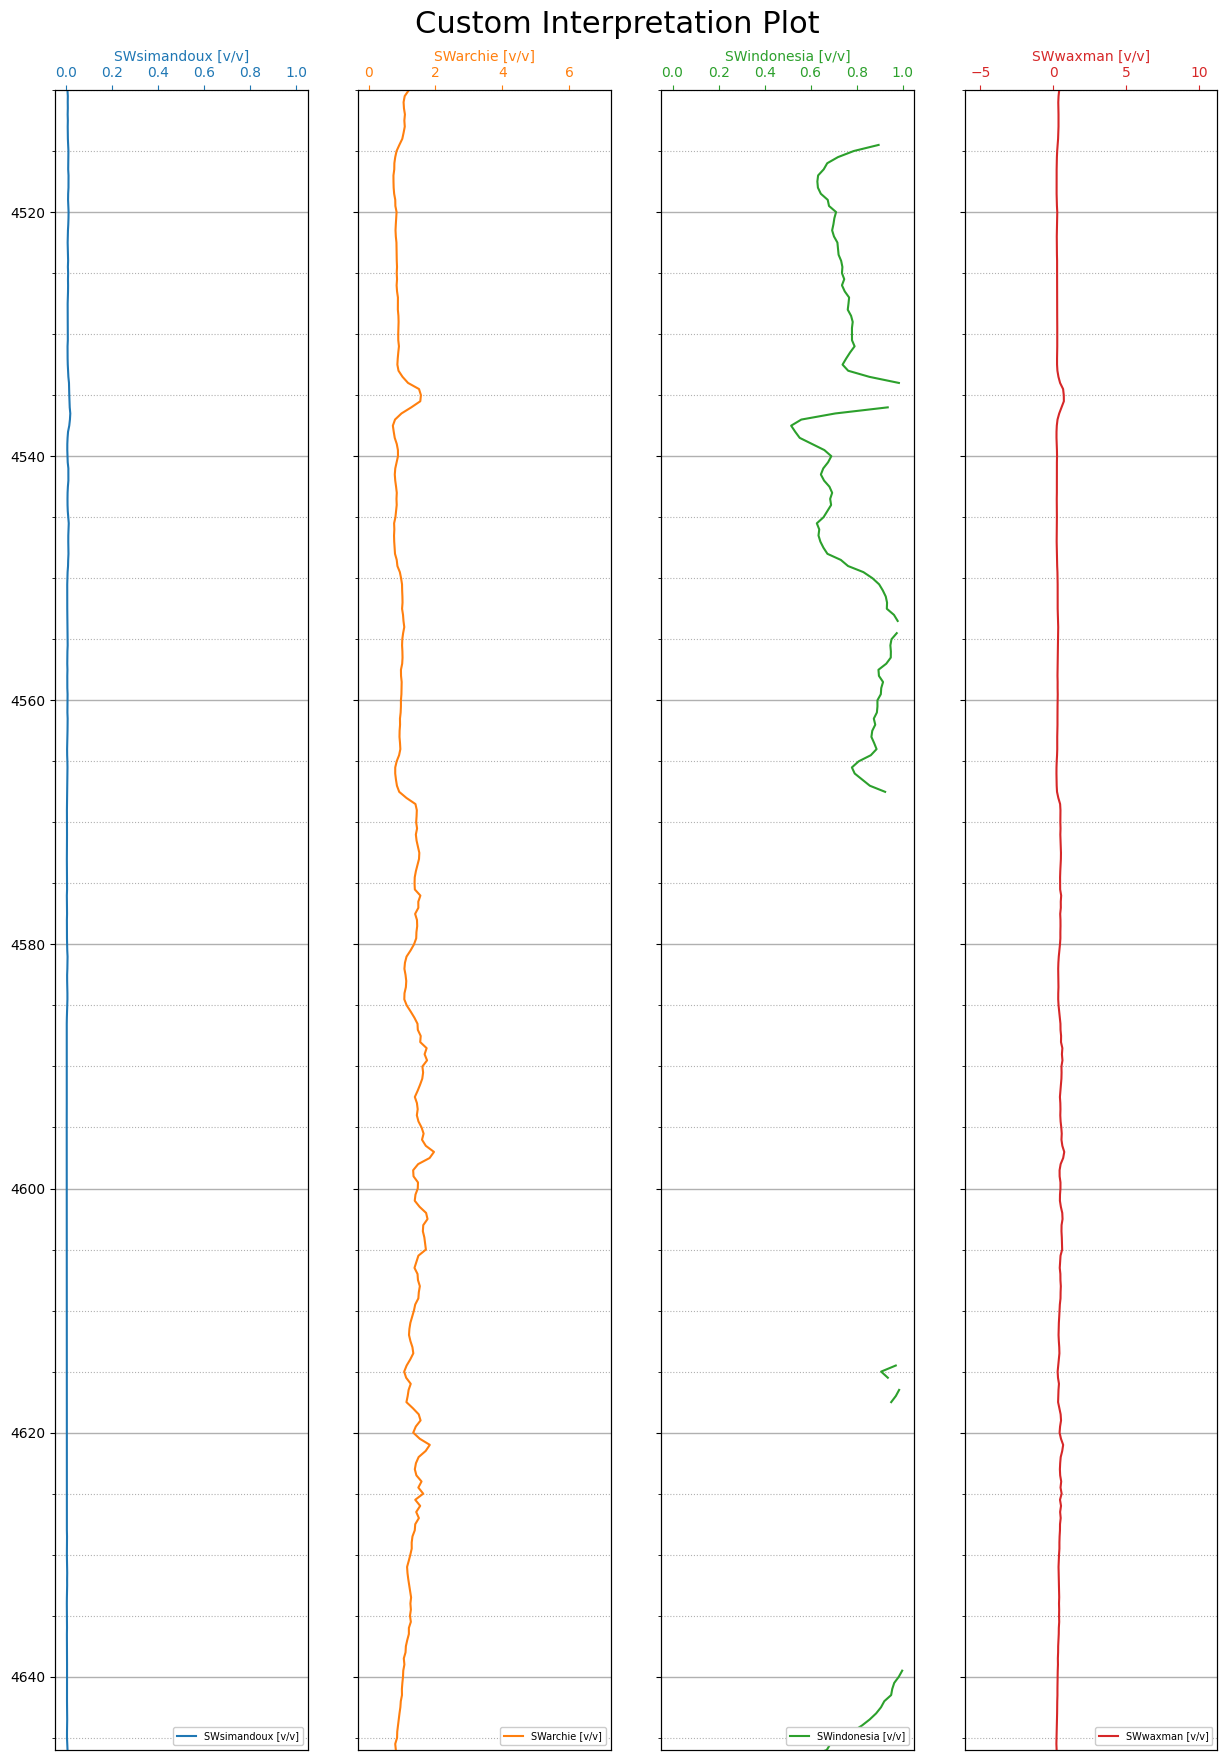

In [56]:
custom_interpretation_plot(logs, depth_start, depth_end, custom_logs=["SWsimandoux", "SWarchie", "SWindonesia", "SWwaxman"], units=["v/v", "v/v", "v/v", "v/v"])

## **9. PERMEABILITY CALCULATION**

In [57]:
def perm_timur(phie,sw):
    perm = ((93*(phie**2.2))/sw)**2
    return perm

In [58]:
print(logs.columns)

Index(['WELL', 'DEPT', 'GR', 'DR', 'SR', 'NPHI', 'RHOB', 'DT', 'VSH', 'RW',
       'core_por', 'core_perm', 'VCLGR', 'VCLRT', 'VCLND', 'VCL', 'PHISw',
       'PHISwshc', 'PHISrhg', 'PHISrhgshc', 'PHID', 'PHIDshc', 'PHI_SIMANDOUX',
       'PHIN', 'PHINshc', 'PHIxND', 'PHIE', 'CEC', 'T', 'SWarchie',
       'SWsimandoux', 'SWindonesia', 'SWwaxman', 'BVW', 'matrix'],
      dtype='object')


In [59]:
logs['PERMtimur'] = logs.apply(lambda row: perm_timur(row['PHIE'],row['SWarchie']), axis=1)

In [60]:
#drop logs["perm"] above 1000
logs = logs[logs["PERMtimur"] < 1000]

## **10. DISPLAY THE INTERPRETATION PLOT**
Create a plot template and add the results of volume of clay, saturation, permeability, and porosity.

In [61]:
def interpretation_plot(logs, depth_start, depth_end, GR_min, GR_max, DR_min, DR_max, SR_min, SR_max, RHOB_min, RHOB_max, NPHI_min, NPHI_max, perm,fill):
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12,20), sharey=True)
    fig.suptitle("Interpretation Plot", fontsize=22)
    fig.subplots_adjust(top=0.85,wspace=0.2)

    depth_range = depth_end - depth_start
    if depth_range > 5000:
      major_tick_interval = 1000
      minor_tick_interval = 100
    elif depth_range > 1000:
      major_tick_interval = 500
      minor_tick_interval = 50
    else:
      major_tick_interval = 100
      minor_tick_interval = 10

    #General setting for all axis
    for axes in ax:
        axes.set_ylim (depth_start,depth_end)
        axes.invert_yaxis()
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        axes.yaxis.set_major_locator(ticker.MultipleLocator(major_tick_interval))
        axes.yaxis.set_minor_locator(ticker.MultipleLocator(minor_tick_interval))
        axes.get_xaxis().set_visible(False)


    #1st track: GR, SP, CALI track
    if 'SP' in logs.columns:
      ax01=ax[0].twiny()
      if SP_min != "auto" and SP_max != "auto":
        ax01.set_xlim(SP_min,SP_max)
      ax01.plot(logs.SP, logs.DEPT, label='SP[mV]', color='blue')
      ax01.set_xlabel('SP[mV]',color='blue')
      ax01.tick_params(axis='x', colors='blue')
    if 'CALI' in logs.columns:
      ax02=ax[0].twiny()
      if CALI_min != "auto" and CALI_max != "auto":
        ax02.set_xlim(CALI_min,CALI_max)
      ax02.grid(True)
      ax02.plot(logs.CALI, logs.DEPT, '--', label='CALI[in]', color='black')
      ax02.spines['top'].set_position(('outward',40))
      ax02.set_xlabel('CALI[in]',color='black')
      ax02.tick_params(axis='x', colors='black')
    if 'GR' in logs.columns:
      ax03=ax[0].twiny()
      if GR_min != "auto" and GR_max != "auto":
        ax03.set_xlim(GR_min,GR_max)
      ax03.plot(logs.GR, logs.DEPT, label='GR[api]', color='green')
      ax03.spines['top'].set_position(('outward',80))
      ax03.set_xlabel('GR[api]',color='green')
      ax03.tick_params(axis='x', colors='green')



    #2nd track: Resistivities
    ax11=ax[1].twiny()
    if DR_min != "auto" and DR_max != "auto":
        ax11.set_xlim(DR_min,DR_max)
    ax11.set_xscale('log')
    ax11.grid(True, which="both")
    ax11.spines['top'].set_position(('outward',80))
    ax11.set_xlabel('DR[m.ohm]', color='red')
    ax11.plot(logs.DR, logs.DEPT, label='DR[m.ohm]', color='red')
    ax11.tick_params(axis='x', colors='red')

    ax12=ax[1].twiny()
    # if MR_min != "auto" and MR_max != "auto":
    #     ax12.set_xlim(MR_min,MR_max)
    # ax12.set_xscale('log')
    # ax12.plot(logs.MR, logs.DEPT, label='MR[m.ohm]', color='purple')
    # ax12.spines['top'].set_position(('outward',40))
    # ax12.set_xlabel('MR[m.ohm]', color='purple')
    # ax12.tick_params(axis='x', colors='purple')

    ax13=ax[1].twiny()
    if SR_min != "auto" and SR_max != "auto":
        ax13.set_xlim(SR_min,SR_max)
    ax13.set_xscale('log')
    ax13.plot(logs.SR, logs.DEPT, '--',label='SR[m.ohm]', color='black')
    ax13.spines['top'].set_position(('outward',0))
    ax13.set_xlabel('SR[m.ohm]',color='black')
    ax13.tick_params(axis='x', colors='black')



    #3rd track: DT, RHOB, NPHI track
    # ax21=ax[2].twiny()
    # ax21.grid(True)
    # if DT_min != "auto" and DT_max != "auto":
    #     ax21.set_xlim(DT_min,DT_max)
    # ax21.spines['top'].set_position(('outward',0))
    # ax21.set_xlabel('DT[us/ft]')
    # ax21.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
    # ax21.set_xlabel('DT[us/ft]', color='blue')
    # ax21.tick_params(axis='x', colors='blue')

    ax22=ax[2].twiny()
    if NPHI_min != "auto" and NPHI_max != "auto":
        ax22.set_xlim(NPHI_min,NPHI_max)
    ax22.invert_xaxis()
    ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[%]', color='green')
    ax22.spines['top'].set_position(('outward',40))
    ax22.set_xlabel('NPHI[%]', color='green')
    ax22.tick_params(axis='x', colors='green')

    ax23=ax[2].twiny()
    if RHOB_min != "auto" and RHOB_max != "auto":
        ax23.set_xlim(RHOB_min,RHOB_max)
    ax23.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red')
    ax23.spines['top'].set_position(('outward',80))
    ax23.set_xlabel('RHOB[g/cc]',color='red')
    ax23.tick_params(axis='x', colors='red')



    #4th track: SW
    ax31=ax[3].twiny()
    ax31.grid(True)
    ax31.set_xlim(1,0)
    if fill == "yes":
        # ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs.SWwaxman,color='lightgreen',label='waxman - archie')
        # ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs.SWindonesia,color='lightblue',label='indonesia - archie')
        ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs.SWsimandoux,color='red',label='simandoux - archie')
    ax31.plot(logs.SWarchie, logs.DEPT, label='SW[Archie]', color='black',linewidth=1)
    ax31.spines['top'].set_position(('outward',0))
    ax31.set_xlabel('SW Archie [frac]', color='black')
    ax31.tick_params(axis='x', colors='black')

    # ax32=ax[3].twiny()
    # ax32.set_xlim(1,0)
    # ax32.plot(logs.SWwaxman, logs.DEPT, label="SW[Waxman]",color="red")
    # ax32.spines['top'].set_position(('outward',40))
    # ax32.set_xlabel('SW Waxman [frac]', color='red')
    # ax32.tick_params(axis='x', colors='red')

    # ax33=ax[3].twiny()
    # ax33.set_xlim(1,0)
    # ax33.plot(logs["SWindonesia"], logs.DEPT, label="SW[Indonesia]",color="blue")
    # ax33.spines['top'].set_position(('outward',80))
    # ax33.set_xlabel('SW Indonesia [frac]', color='blue')
    # ax33.tick_params(axis='x', colors='blue')

    ax32=ax[3].twiny()
    ax32.set_xlim(1,0)
    ax32.plot(logs["SWsimandoux"], logs.DEPT, label="SW[simandoux]",color="green")
    ax32.spines['top'].set_position(('outward',40))
    ax32.set_xlabel('SW simandoux [frac]', color='green')
    ax32.tick_params(axis='x', colors='green')


    #4th track: Permeability
    ax41=ax[4].twiny()
    ax41.plot(logs[perm], logs.DEPT, label="perm",color="green")
    ax41.spines['top'].set_position(('outward',0))
    ax41.set_xlabel('PERM [mD]', color='green')
    ax41.tick_params(axis='x', colors='green')

    ax42=ax[4].twiny()
    ax42.scatter(core_selected_data.core_perm, core_selected_data.DEPT, label='C_PERM', color='red',linewidths=0.5)
    ax42.spines['top'].set_position(('outward',40))
    ax42.set_xlabel('PERM-CORE', color='red')
    ax42.tick_params(axis='x', colors='red')



    #5th track: PHIE, BVW
    ax51=ax[5].twiny()
    ax51.grid(True)
    ax51.set_xlim(1,0)
    ax51.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black', linewidth=0.5, alpha=0.5)
    ax51.fill_betweenx(logs.DEPT,0,logs.BVW,color='lightblue', alpha=0.5)
    ax51.spines['top'].set_position(('outward',0))
    ax51.set_xlabel('PHIE-LOG', color='black')
    ax51.tick_params(axis='x', colors='black')

    ax52=ax[5].twiny()
    ax52.set_xlim(1,0)
    ax52.plot(logs.BVW, logs.DEPT, label='BVW', color='black', alpha=0.5)
    ax52.fill_betweenx(logs.DEPT,logs.PHIE, logs.BVW,color='green',alpha=0.2)
    ax52.scatter(core_selected_data.core_por, core_selected_data.DEPT, label='C_PHIE', color='red',linewidths=0.5)
    ax52.spines['top'].set_position(('outward',40))
    ax52.set_xlabel('BVW', color='black')
    ax52.tick_params(axis='x', colors='black')

    ax53=ax[5].twiny()
    ax53.set_xlim(1,0)
    ax53.scatter(core_selected_data.core_por, core_selected_data.DEPT, label='C_PHIE', color='red',linewidths=0.5)
    ax53.spines['top'].set_position(('outward',80))
    ax53.set_xlabel('PHIE-CORE', color='red')
    ax53.tick_params(axis='x', colors='red')



    #6th track: PHIE, MATRIX, VCL
    ax60=ax[6].twiny()
    ax60.set_xlim(1,0)
    ax60.spines['top'].set_position(('outward',0))
    ax60.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black',linewidth=0.5)
    ax60.set_xlabel('Porosity', color='blue')
    ax60.tick_params(axis='x', colors='blue')

    ax61=ax[6].twiny()
    ax61.set_xlim(0,1)
    ax61.spines['top'].set_position(('outward',40))
    ax61.plot(logs.VCL, logs.DEPT, label='VCL', color='green',linewidth=0.5)
    ax61.set_xlabel('VClay', color='green')
    ax61.tick_params(axis='x', colors='green')

    ax62=ax[6].twiny()
    ax62.set_xlim(1,0)
    ax62.spines['top'].set_position(('outward',80))
    ax62.fill_betweenx(logs.DEPT,0,logs.PHIE,color='lightgray',label='porosity')
    ax62.fill_betweenx(logs.DEPT,logs.PHIE,1-logs.VCL,color='orange',label='matrix')
    ax62.fill_betweenx(logs.DEPT,1-logs.VCL,1,color='lightgreen',label= 'Vclay')
    ax62.set_xlabel('Matrix', color='orange')
    ax62.tick_params(axis='x', colors='orange')
    ax62.legend(loc='lower left')


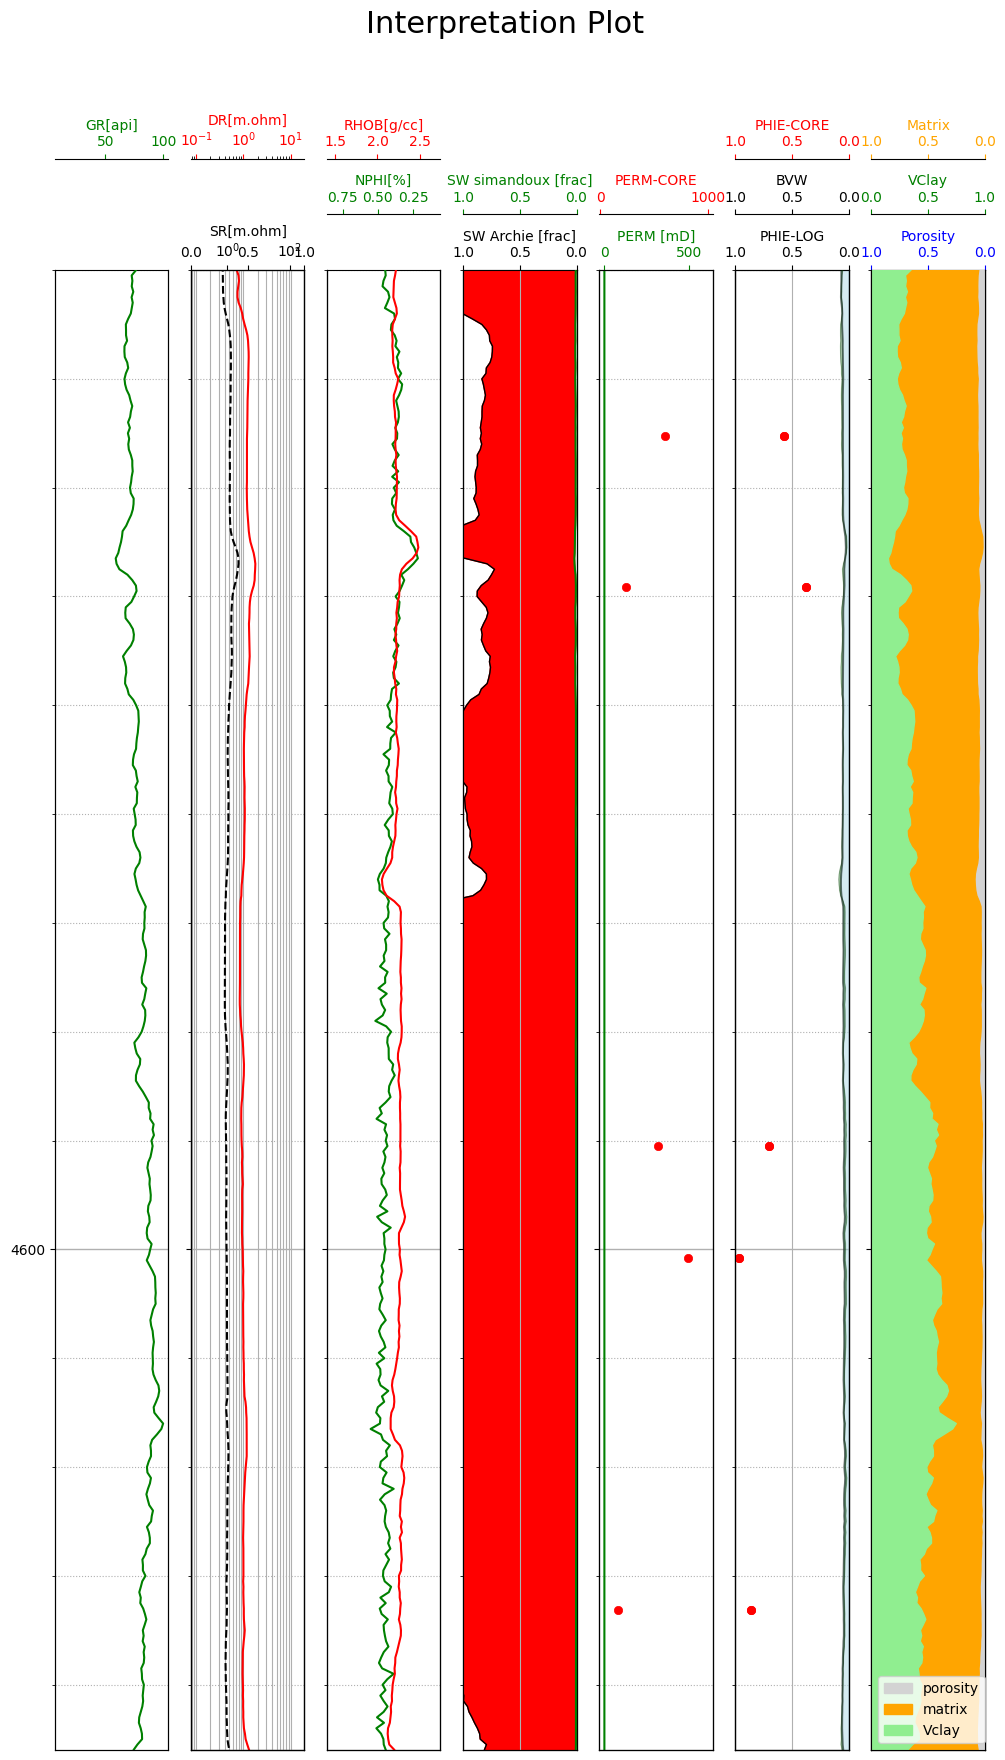

In [62]:
NPHI_max = 100
NPHI_min = 0
GR_min="auto"
GR_max="auto"
DR_min="auto"
DR_max="auto"
MR_min="auto"
MR_max="auto"
SR_min="auto"
SR_max="auto"
RHOB_min='auto'
RHOB_max='auto'
NPHI_min='auto'
NPHI_max='auto'
interpretation_plot(
    logs,
    depth_start,
    depth_end,
    # SP_min,
    # SP_max,
    # CALI_min,
    # CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    # MR_min,
    # MR_max,
    SR_min,
    SR_max,
    RHOB_min,
    RHOB_max,
    NPHI_min,
    NPHI_max,
    # DT_min,
    # DT_max,
    "PERMtimur",
    "yes"
    )

In [63]:
# Specify the file path where you want to save the Excel file
file_path = "../results/output1.xlsx"

# Export the DataFrame to an Excel file
logs.to_excel(file_path, index=False)  # Set index=False to exclude the index column

print(f"DataFrame has been exported to {file_path}")


DataFrame has been exported to ../results/output1.xlsx
